In [210]:
%matplotlib inline
import scipy.stats as st
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure
import matplotlib as mpl
import csv
import scipy.optimize as opt
mpl.rcParams['figure.dpi'] = 400


Считаем данные

In [156]:
EPS = 0.0001

filename_1 = 'Канал 1_400nm_0.23mm.csv'
filename_2 = 'Канал 2_400nm_0.23mm.csv'

# cчитаем данные
def read_csv(filename):
    data = [[],[]]
    with open(filename, newline='') as File:  
        reader = csv.reader(File,delimiter=';')
        for row in reader:
            try:
                data[0].append(float(row[0]))
                data[1].append(float(row[1]))
            except ValueError:
                pass
    return np.array(data)

In [157]:
data1 = read_csv(filename_1)
data2 = read_csv(filename_2)

In [173]:
n = np.array([i for i in range(len(data1[0]))])

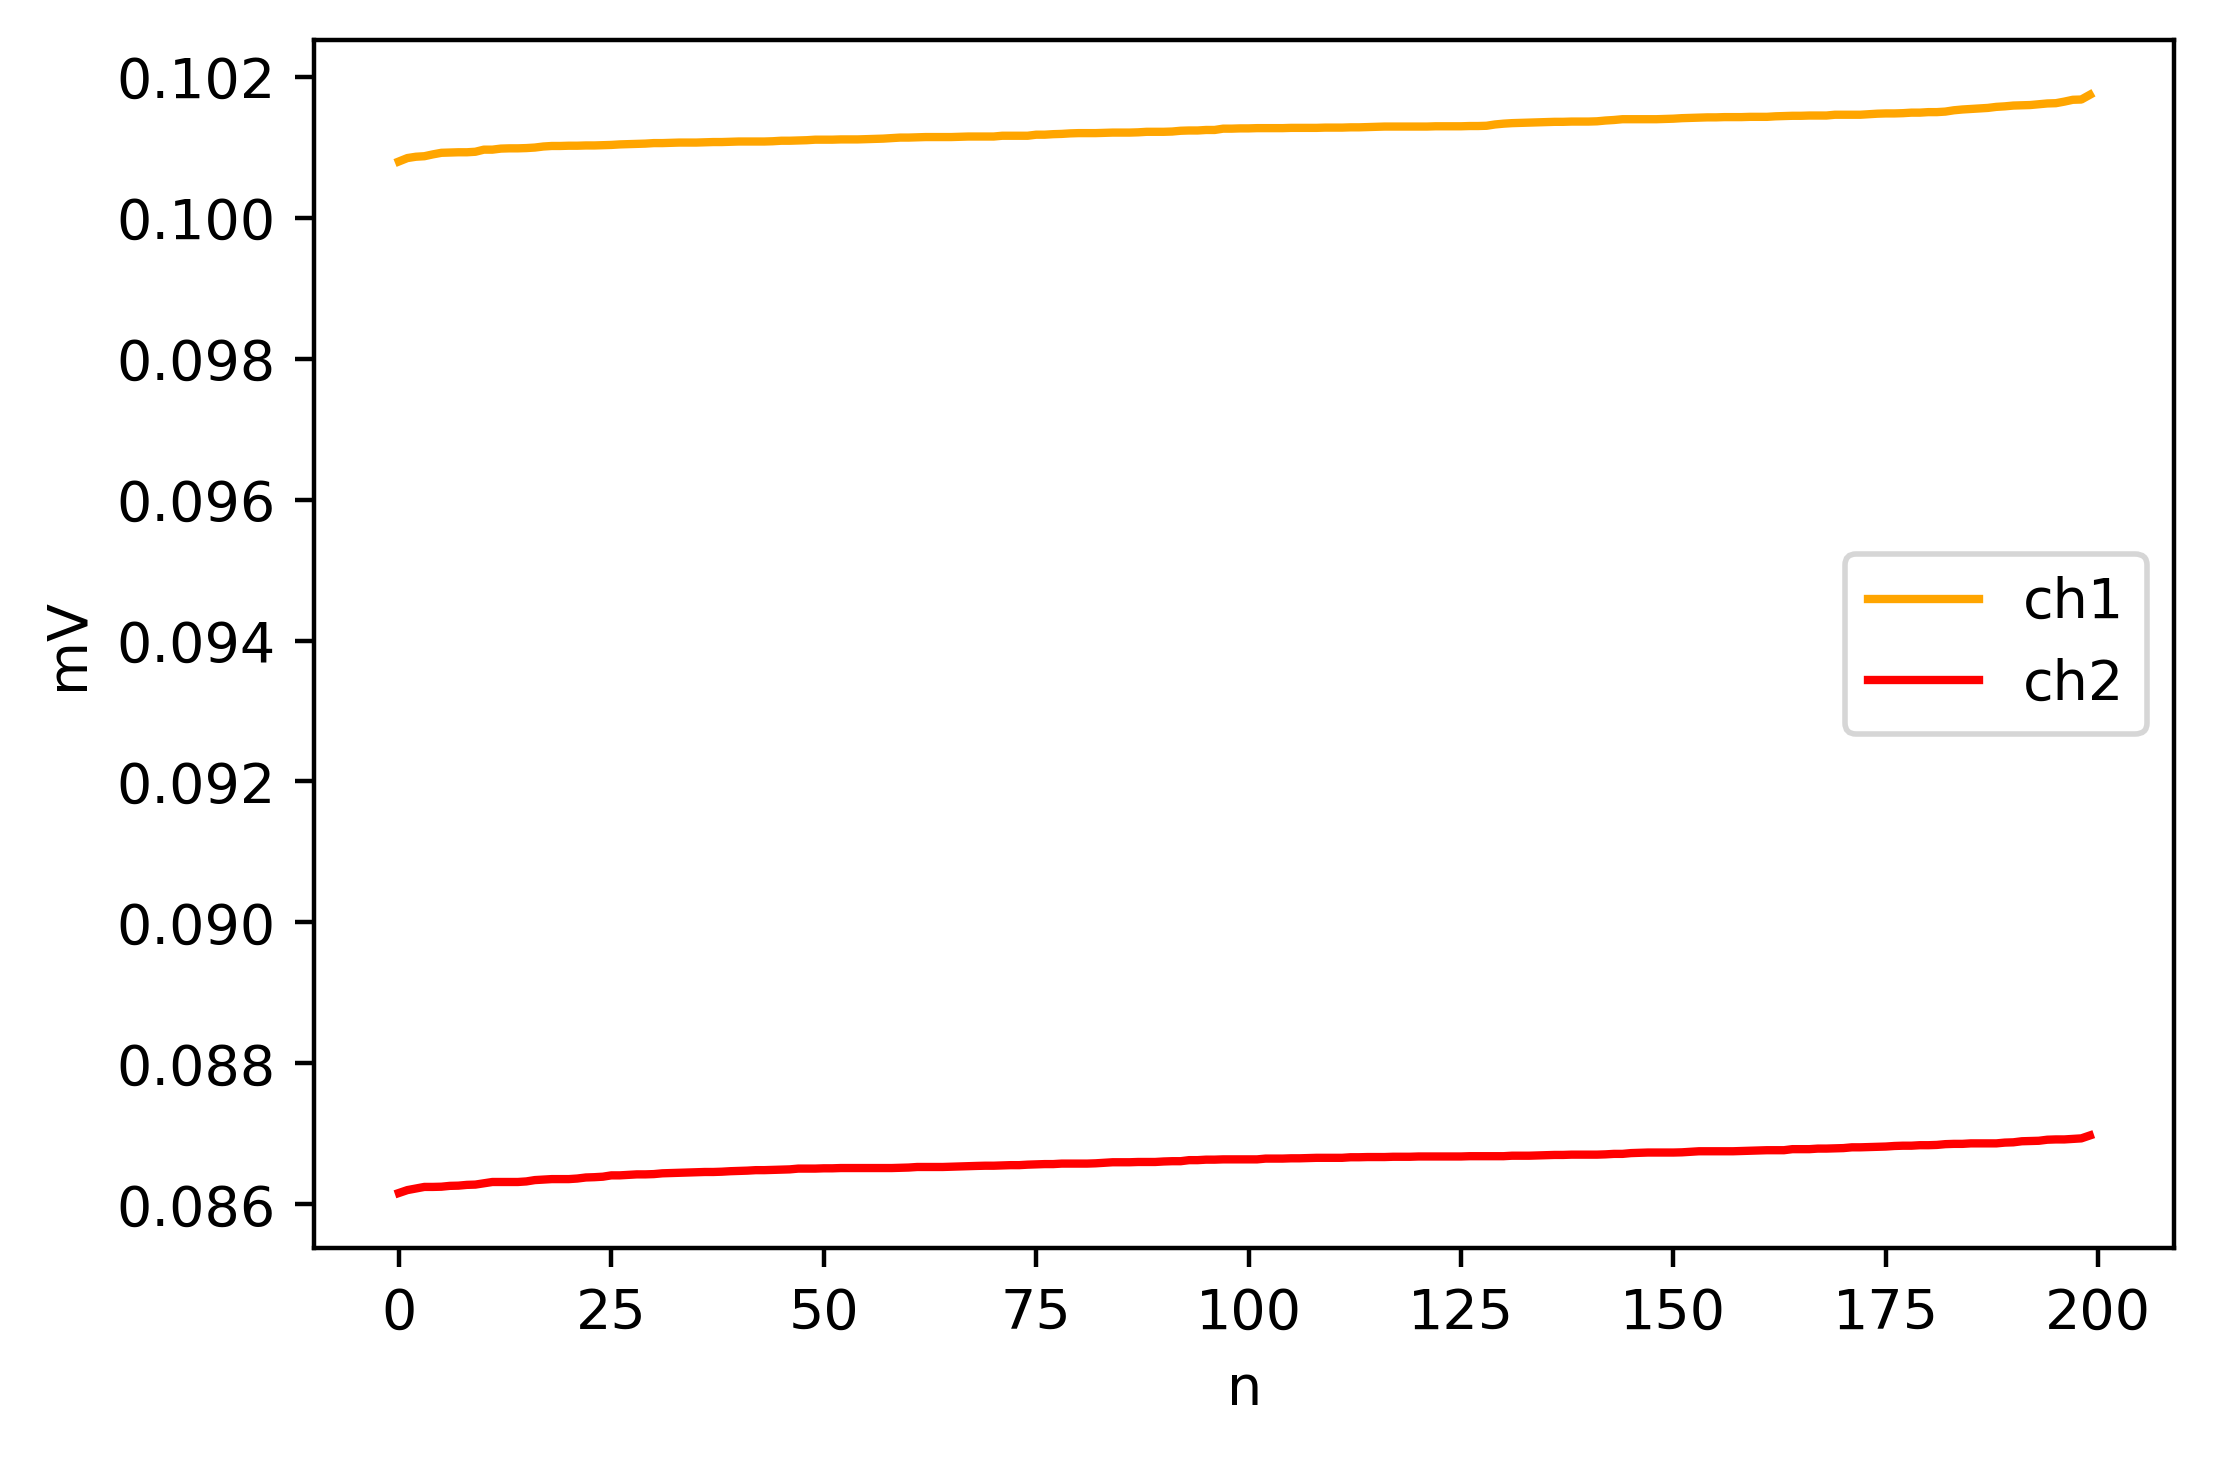

In [389]:
# визуализация данных
ax = plt.gca()
ax.plot(n,data1[0],color="orange",label="ch1")
ax.plot(n,data2[0],color="red",label="ch2")
ax.set_xlabel("n")
ax.set_ylabel("mV")
ax.legend()
plt.show()

In [160]:
def rq(x,y):
    n1 = 0
    n2 = 0
    n3 = 0
    n4 = 0
    
    x_med = np.median(x)
    y_med = np.median(y)
 
    for i in range(len(x)):
        if (x[i] >= x_med) and (y[i] >= y_med):
            n1 += 1
        if (x[i] < x_med) and (y[i] >= y_med):
            n2 += 1
        if (x[i] < x_med) and (y[i] < y_med):
            n3 += 1
        if (x[i] >= x_med) and (y[i] < y_med):
            n4 += 1
    return ((n1 + n3) - (n2 + n4))/len(x)

In [161]:
# class of linear regression
class Linear():
    def __init__(self):
        self.B0 = 0
        self.B1 = 0
    
    def train(self,x,y,method):
        
        # Подбор параметром методом МНК (метод наименьшних квадратов) y = B0 + B1*x
        if method == "MNK":
            self.B1 = ((x * y).mean() - x.mean() * y.mean())/((x * x).mean() - (x.mean())**2)
            self.B0 = y.mean() - x.mean()*self.B1
            
        
        #Подбор параметров методом МНМ
        if method == "MNM":
            self.B1 = rq(x,y) * ((np.quantile(y,3/4) - np.quantile(y,1/4))/(len(y) * 0.5) / ((np.quantile(x,3/4) - np.quantile(x,1/4))/(len(x)*0.5))) 
            self.B0 = np.median(y) - self.B1*np.median(x)
            
    def predict(self,x):
        return self.B0 + self.B1 * x 
    
    def get_B0(self):
        return self.B0
    
    def get_B1(self):
        return self.B1

In [162]:
# Рассмотрим вместе с интервалами
def plotInterval(data,title=""):
    ax = plt.gca()
    ax.set_ylabel("mV")
    ax.set_xlabel("n")
    ax.set_title(title)
    for i in range(len(data)):
        ax.vlines(i, data[i] - EPS, data[i] + EPS)

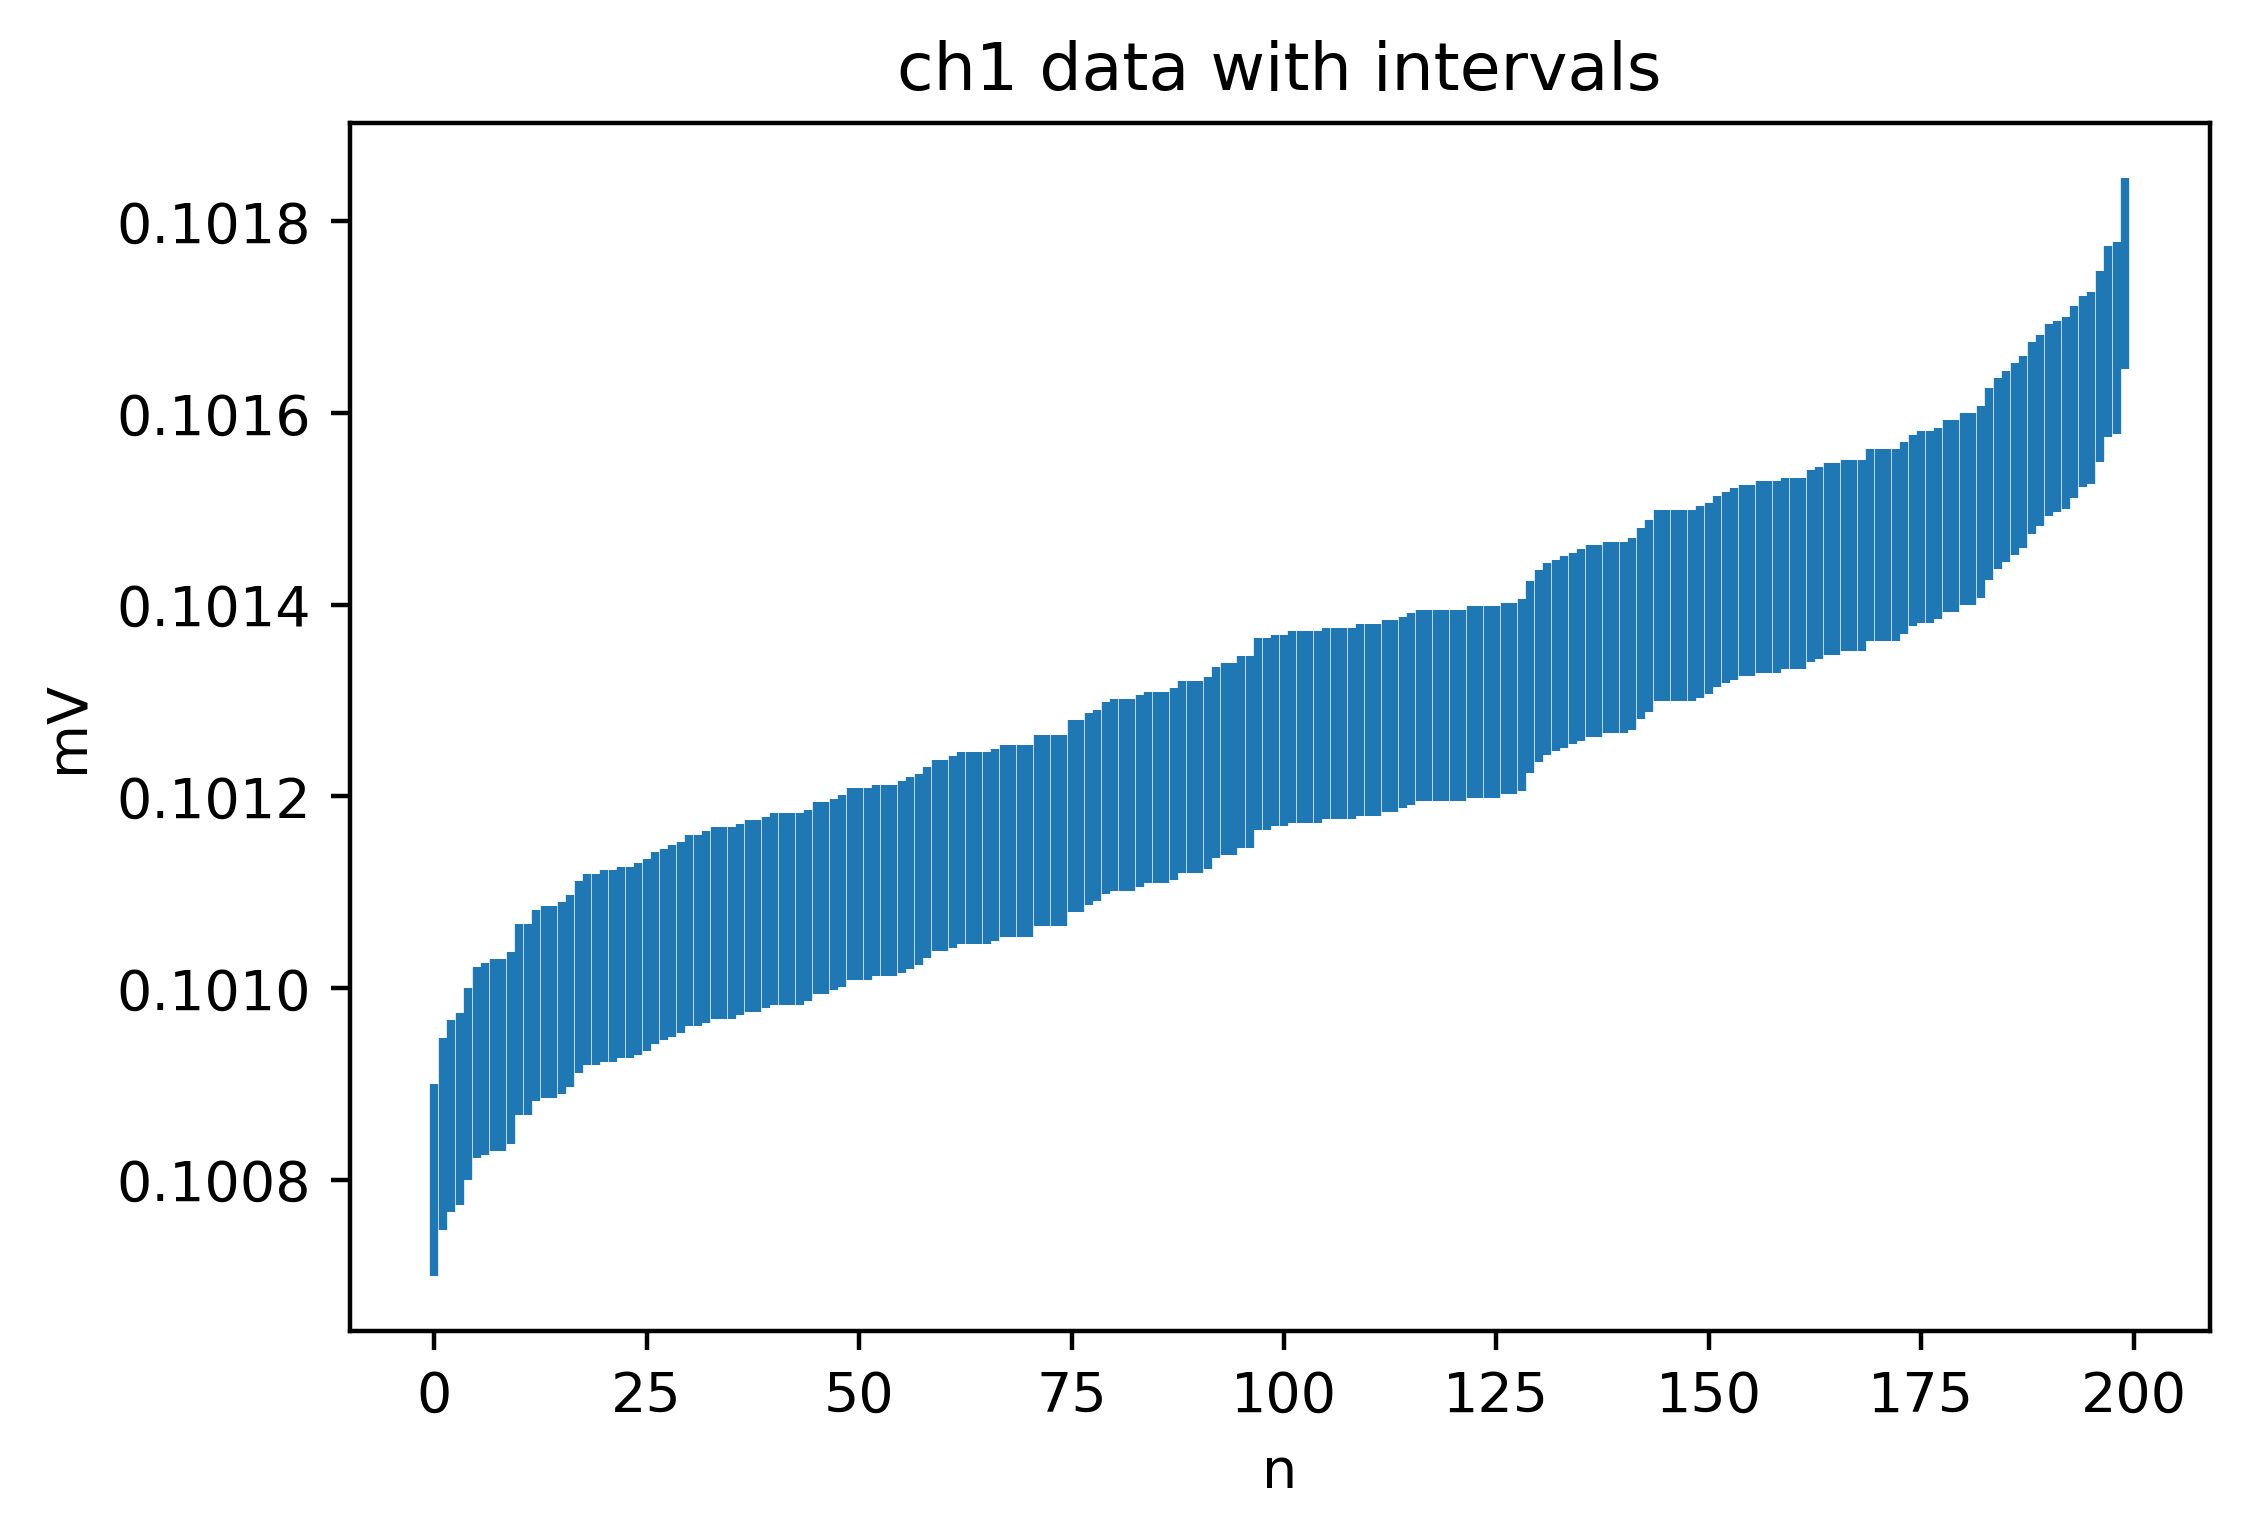

In [163]:
plotInterval(data1[0],"ch1 data with intervals")

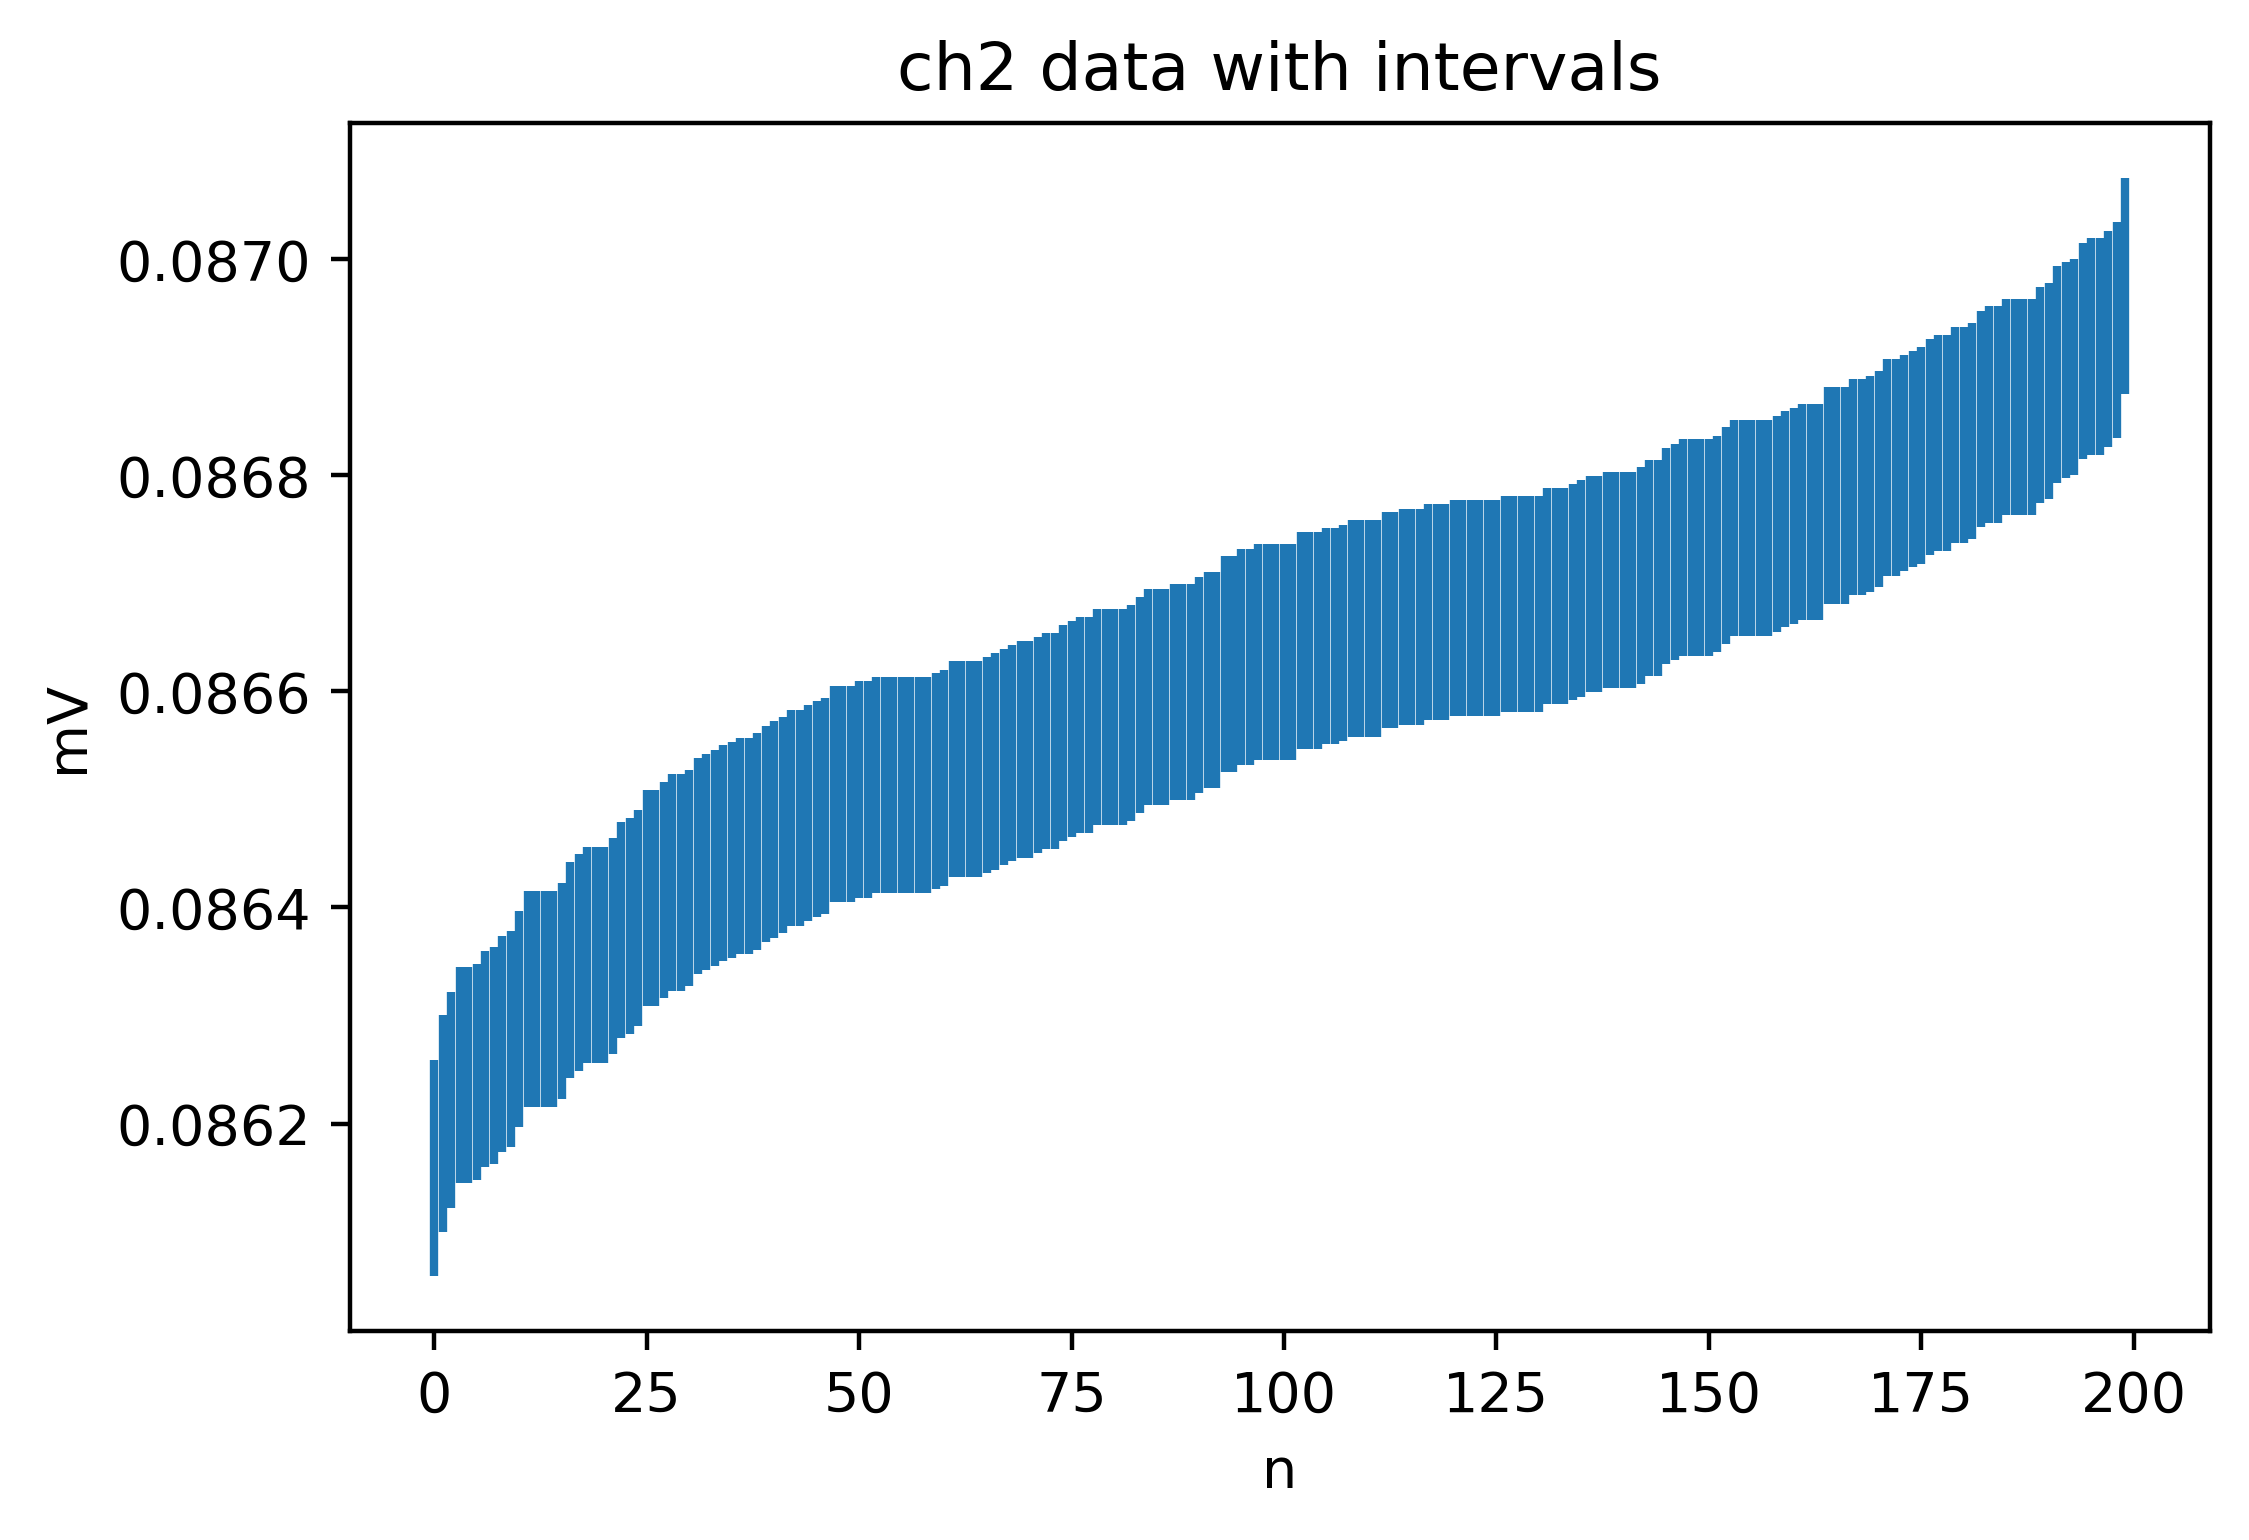

In [397]:
plotInterval(data2[0],"ch2 data with intervals")

In [253]:
def getW(data):
    linear = Linear()
    linear.train(n,data,"MNM")
    val_n = n * linear.get_B1() + linear.get_B0()
    b_ub1 = val_n - data
    b_ub2 = -val_n + data
    c = [1 for i in range(len(val_n))]
    l = 1
    A = np.eye(200)*EPS * -1
    A = np.concatenate((A, A), axis=0)
    b_ub = np.concatenate((b_ub1,b_ub2),axis=0)
    total = opt.linprog(method="simplex",c=c,A_ub = A,b_ub = b_ub)
    return (total.x, linear.get_B0(),linear.get_B1())
    

In [291]:
def plotResult(data,title):
    
    (w,B0,B1) = getW(data)
    ax = plt.gca()
    ax.set_ylabel("mV")
    ax.set_xlabel("n")
    ax.hist(w)
    ax.set_title("w histogram " + title)
    plt.show()
    
    
    # вывод графика линейной регрессии и 
    ax = plt.gca()
    ax.set_ylabel("mV")
    ax.set_xlabel("n")
    ax.set_title("linear regression " + title)
    for i in range(len(data)):
        ax.vlines(i, data[i] - w[i] * EPS, data[i] + w[i] * EPS)
    y = n * B1+ B0
    ax.plot(n,y,color="red")
    plt.show()
    
    # wihout drifting
    ax = plt.gca()
    ax.set_ylabel("mV")
    ax.set_xlabel("n")
    ax.set_title("without linear drifting " + title)
    for i in range(len(data)):
        ax.vlines(i, data[i] - w[i] * EPS - B1 * i, data[i] + w[i] * EPS - B1 * i)
    y = [B0 for i in range(len(n))]
    ax.plot(n,y,color="red")
    plt.show()
    
    print("B0 " + str(B0))
    print("B1 " + str(B1))
    
    # correct
    ax = plt.gca()
    ax.set_ylabel("mV")
    ax.set_xlabel("n")
    ax.set_title("correct " + title)
    ax.hist(data - B1*n)
    
    plt.show()

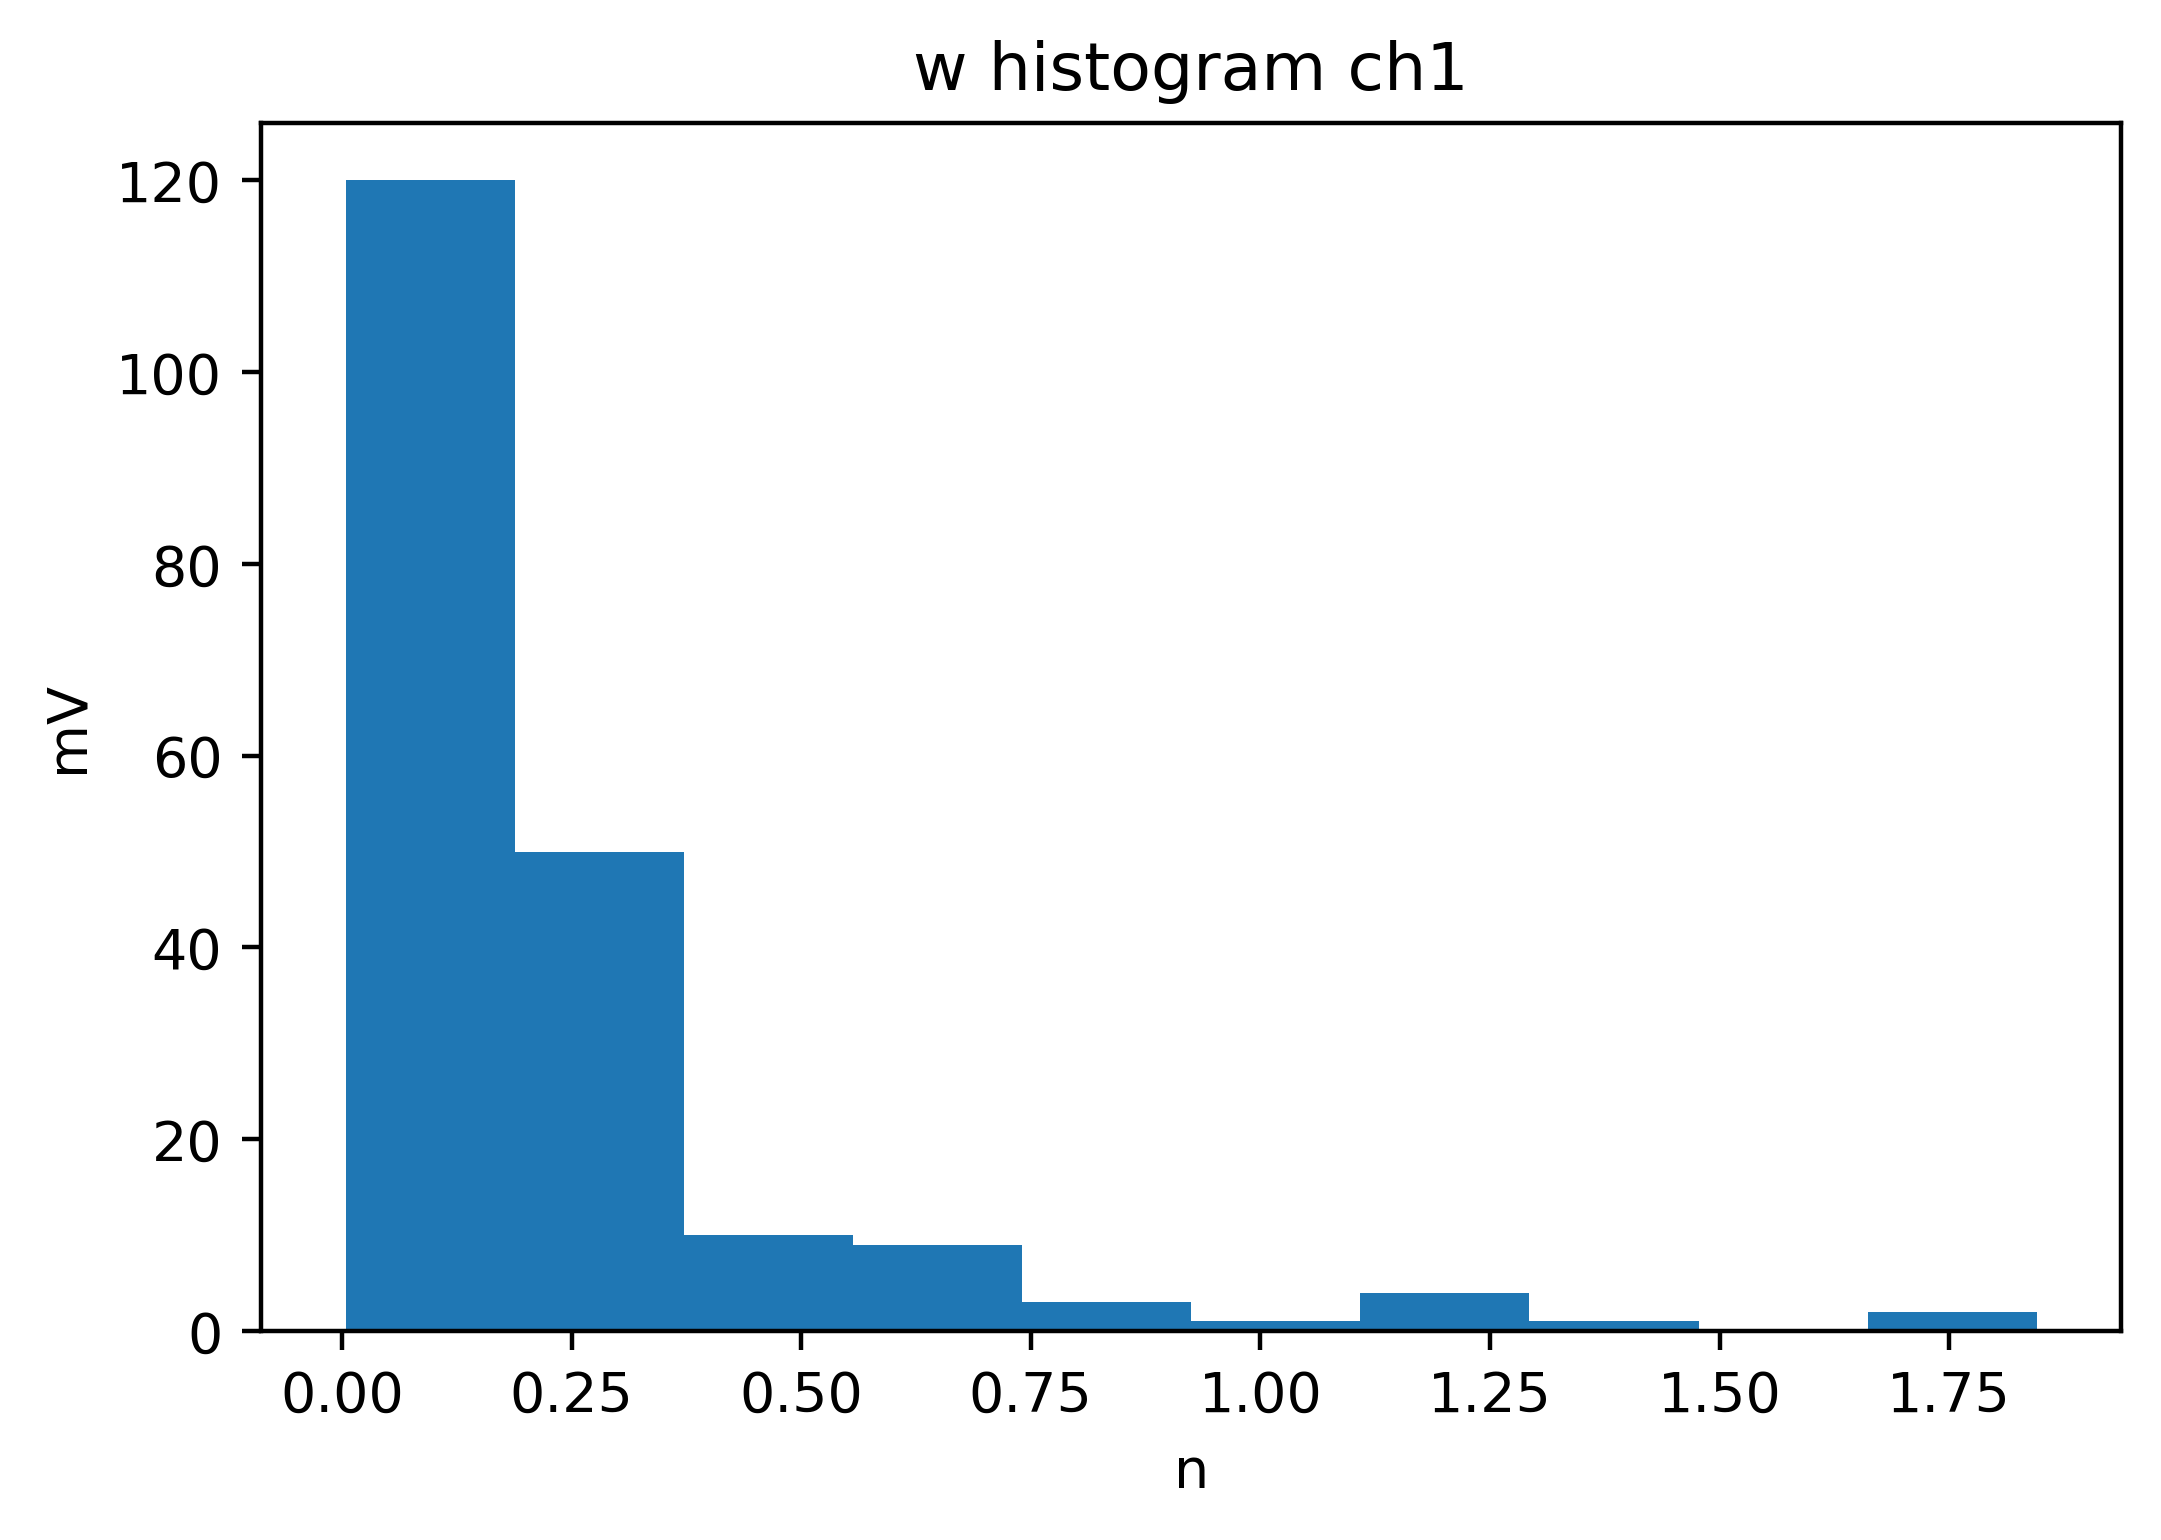

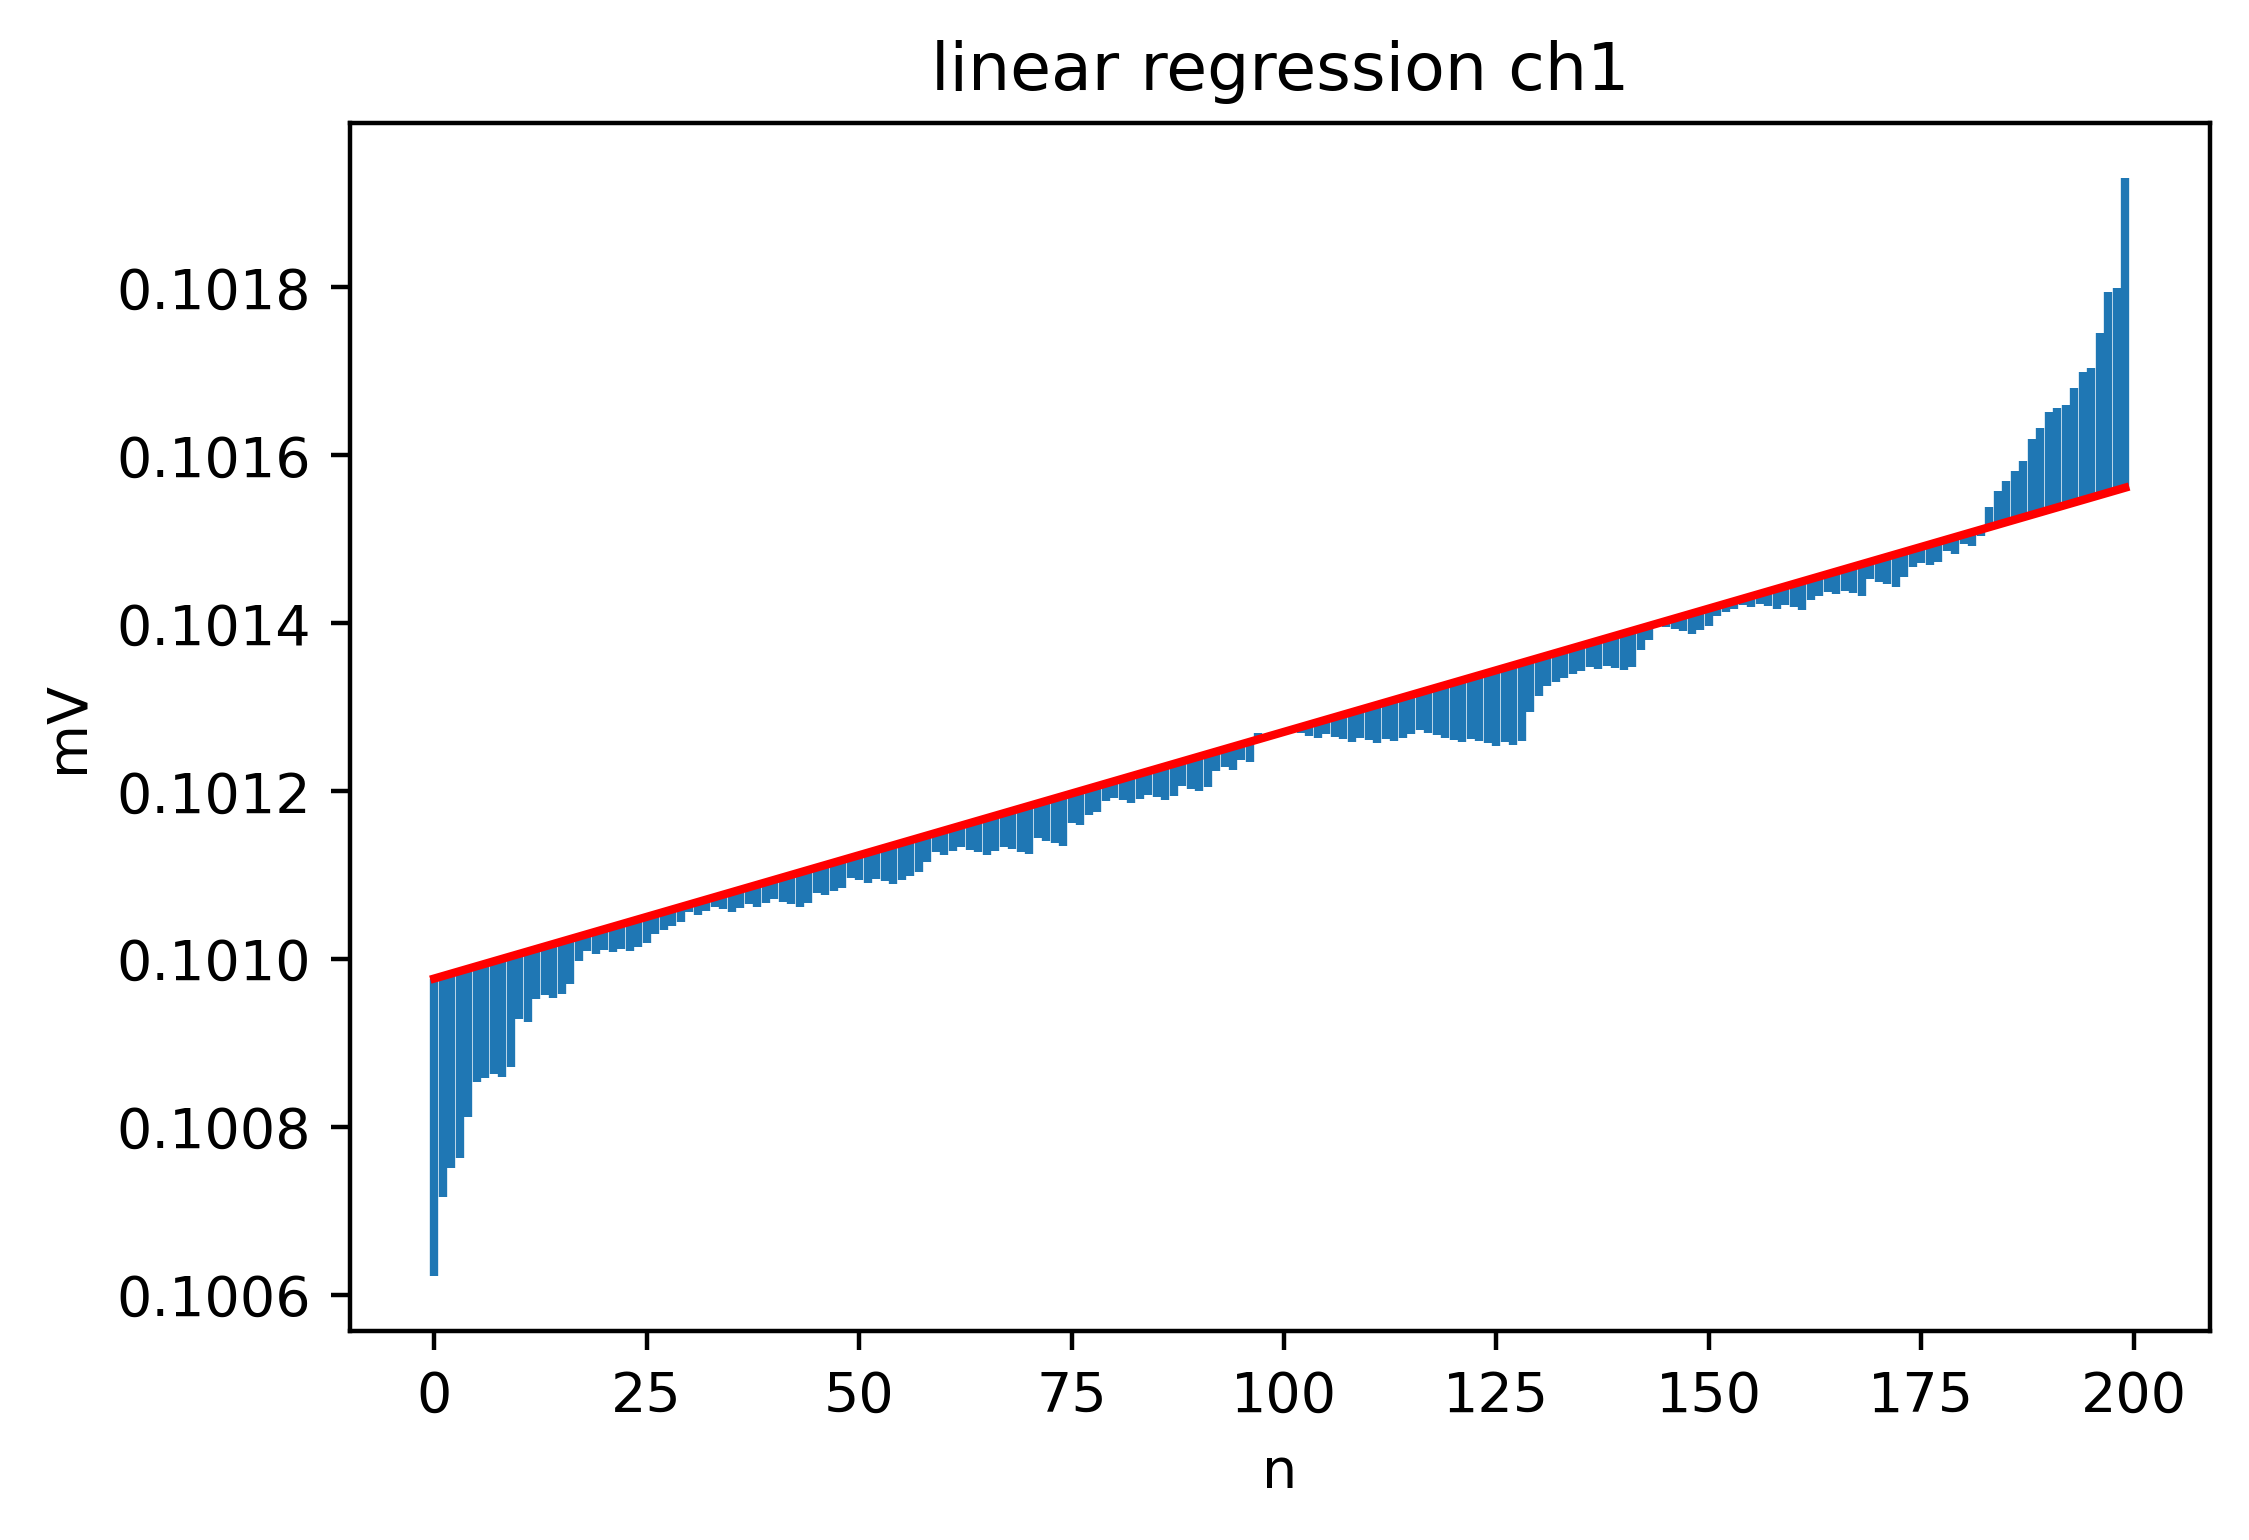

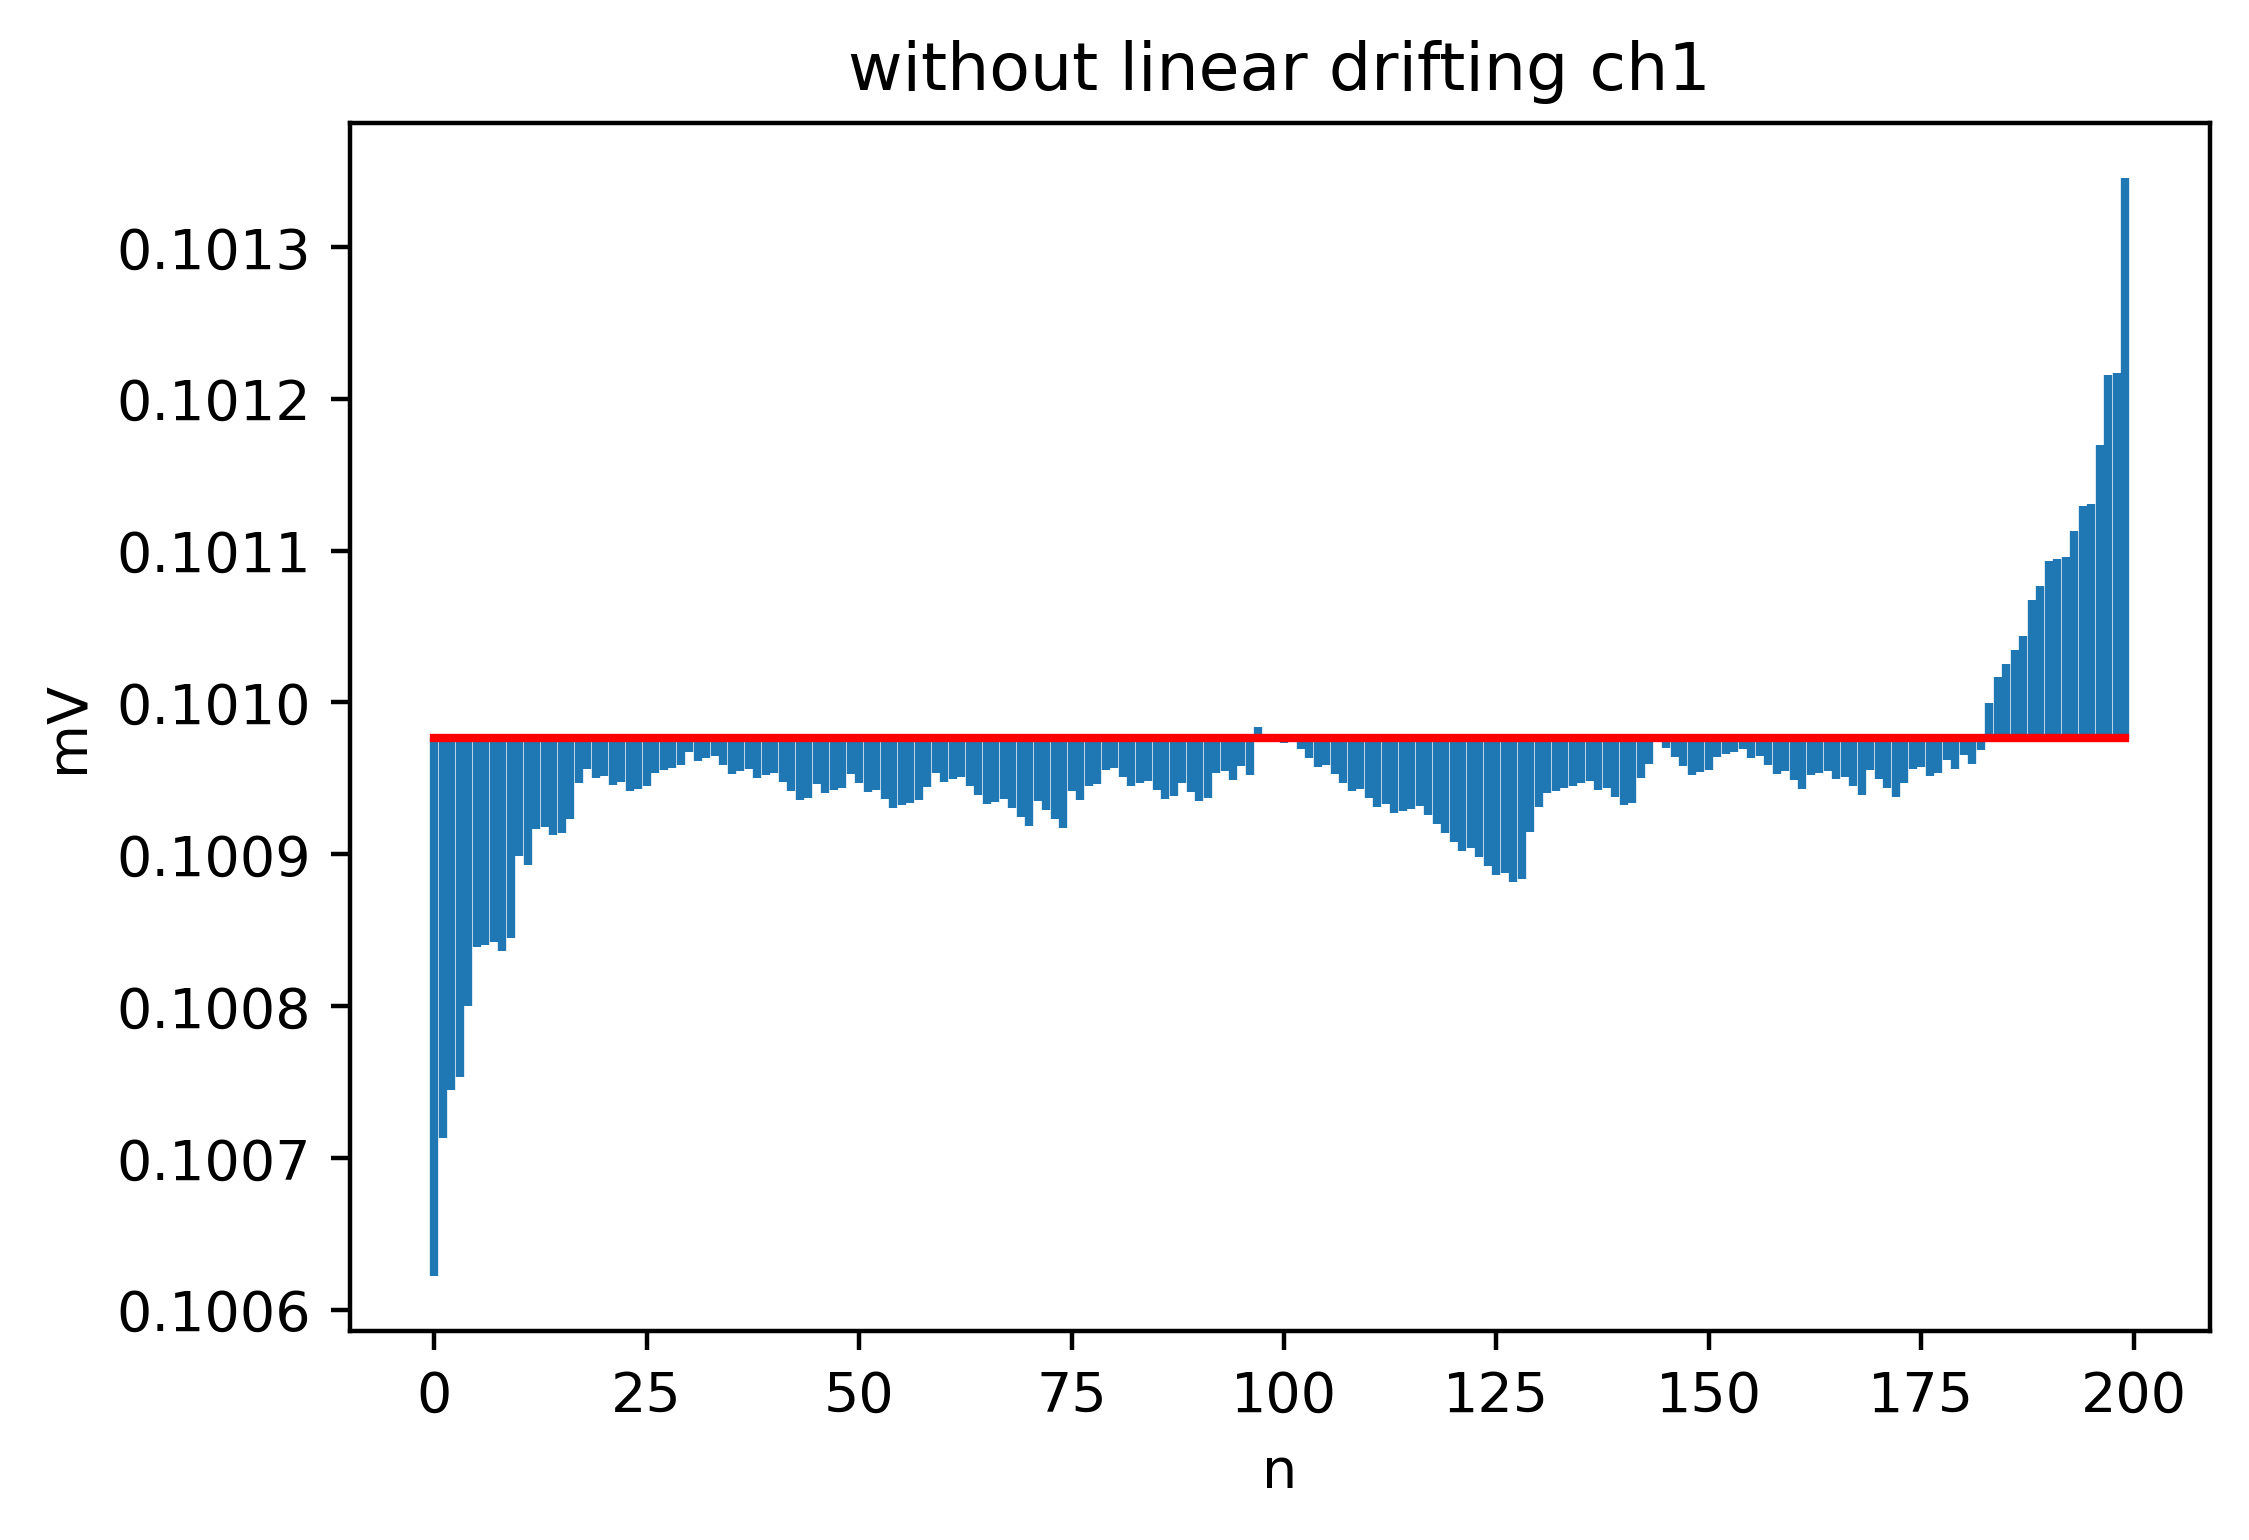

B0 0.10097652725
B1 2.9374145728642836e-06


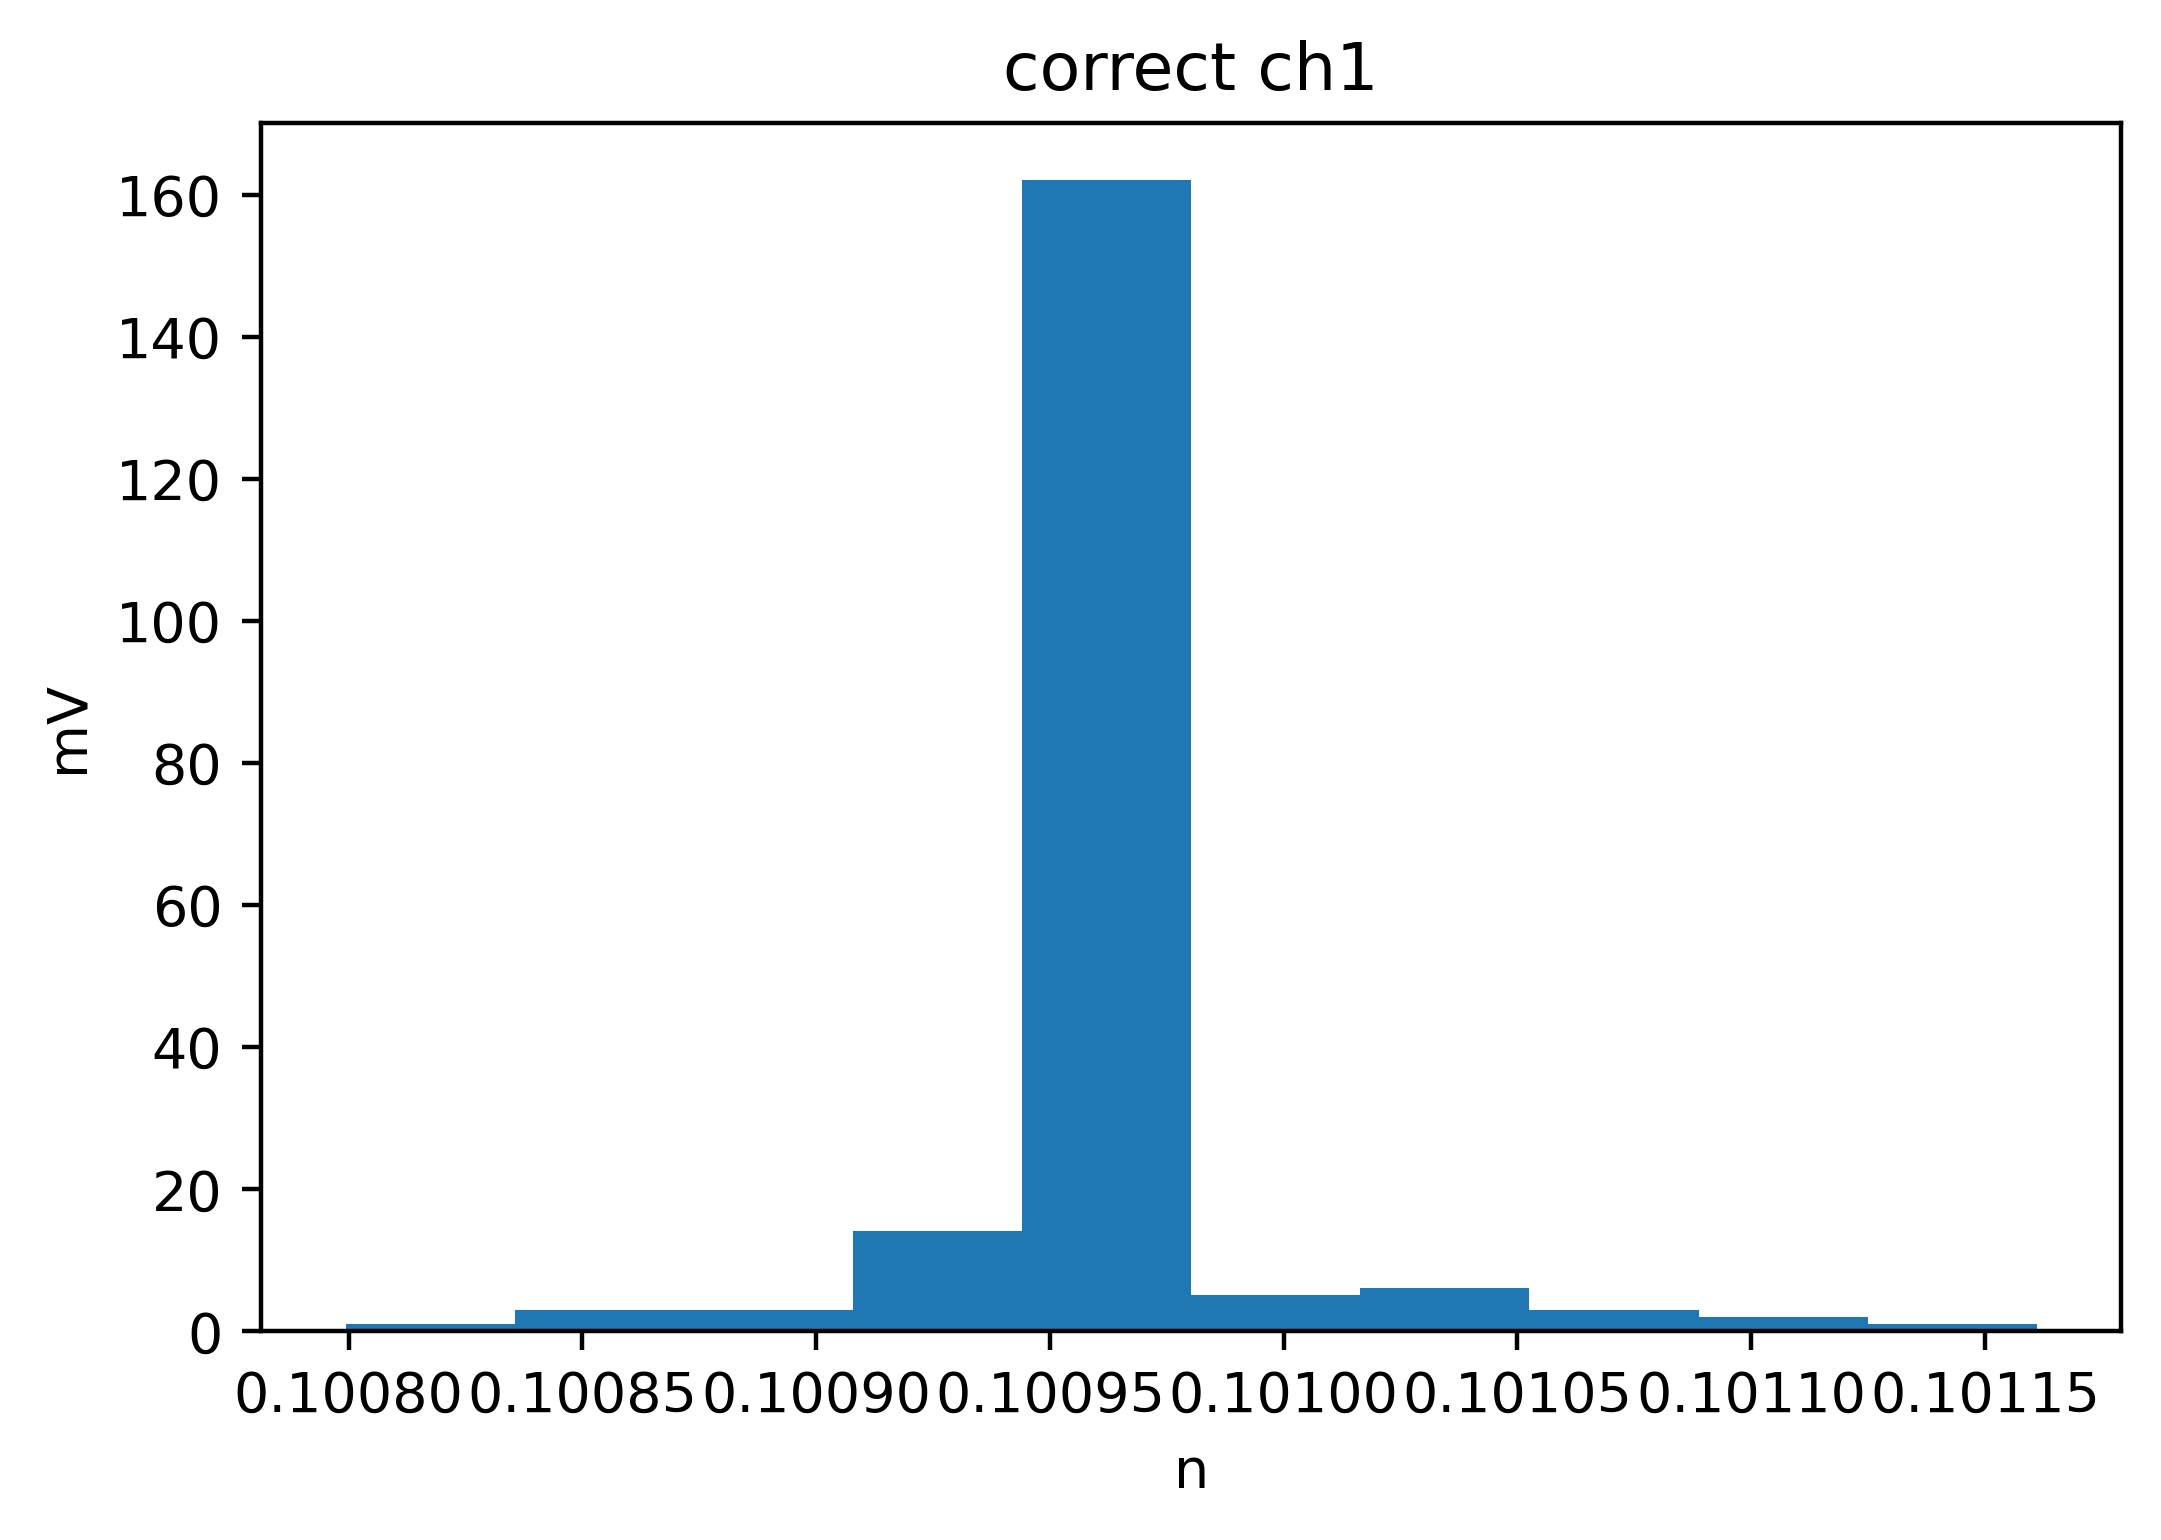

In [292]:
plotResult(data1[0],"ch1")

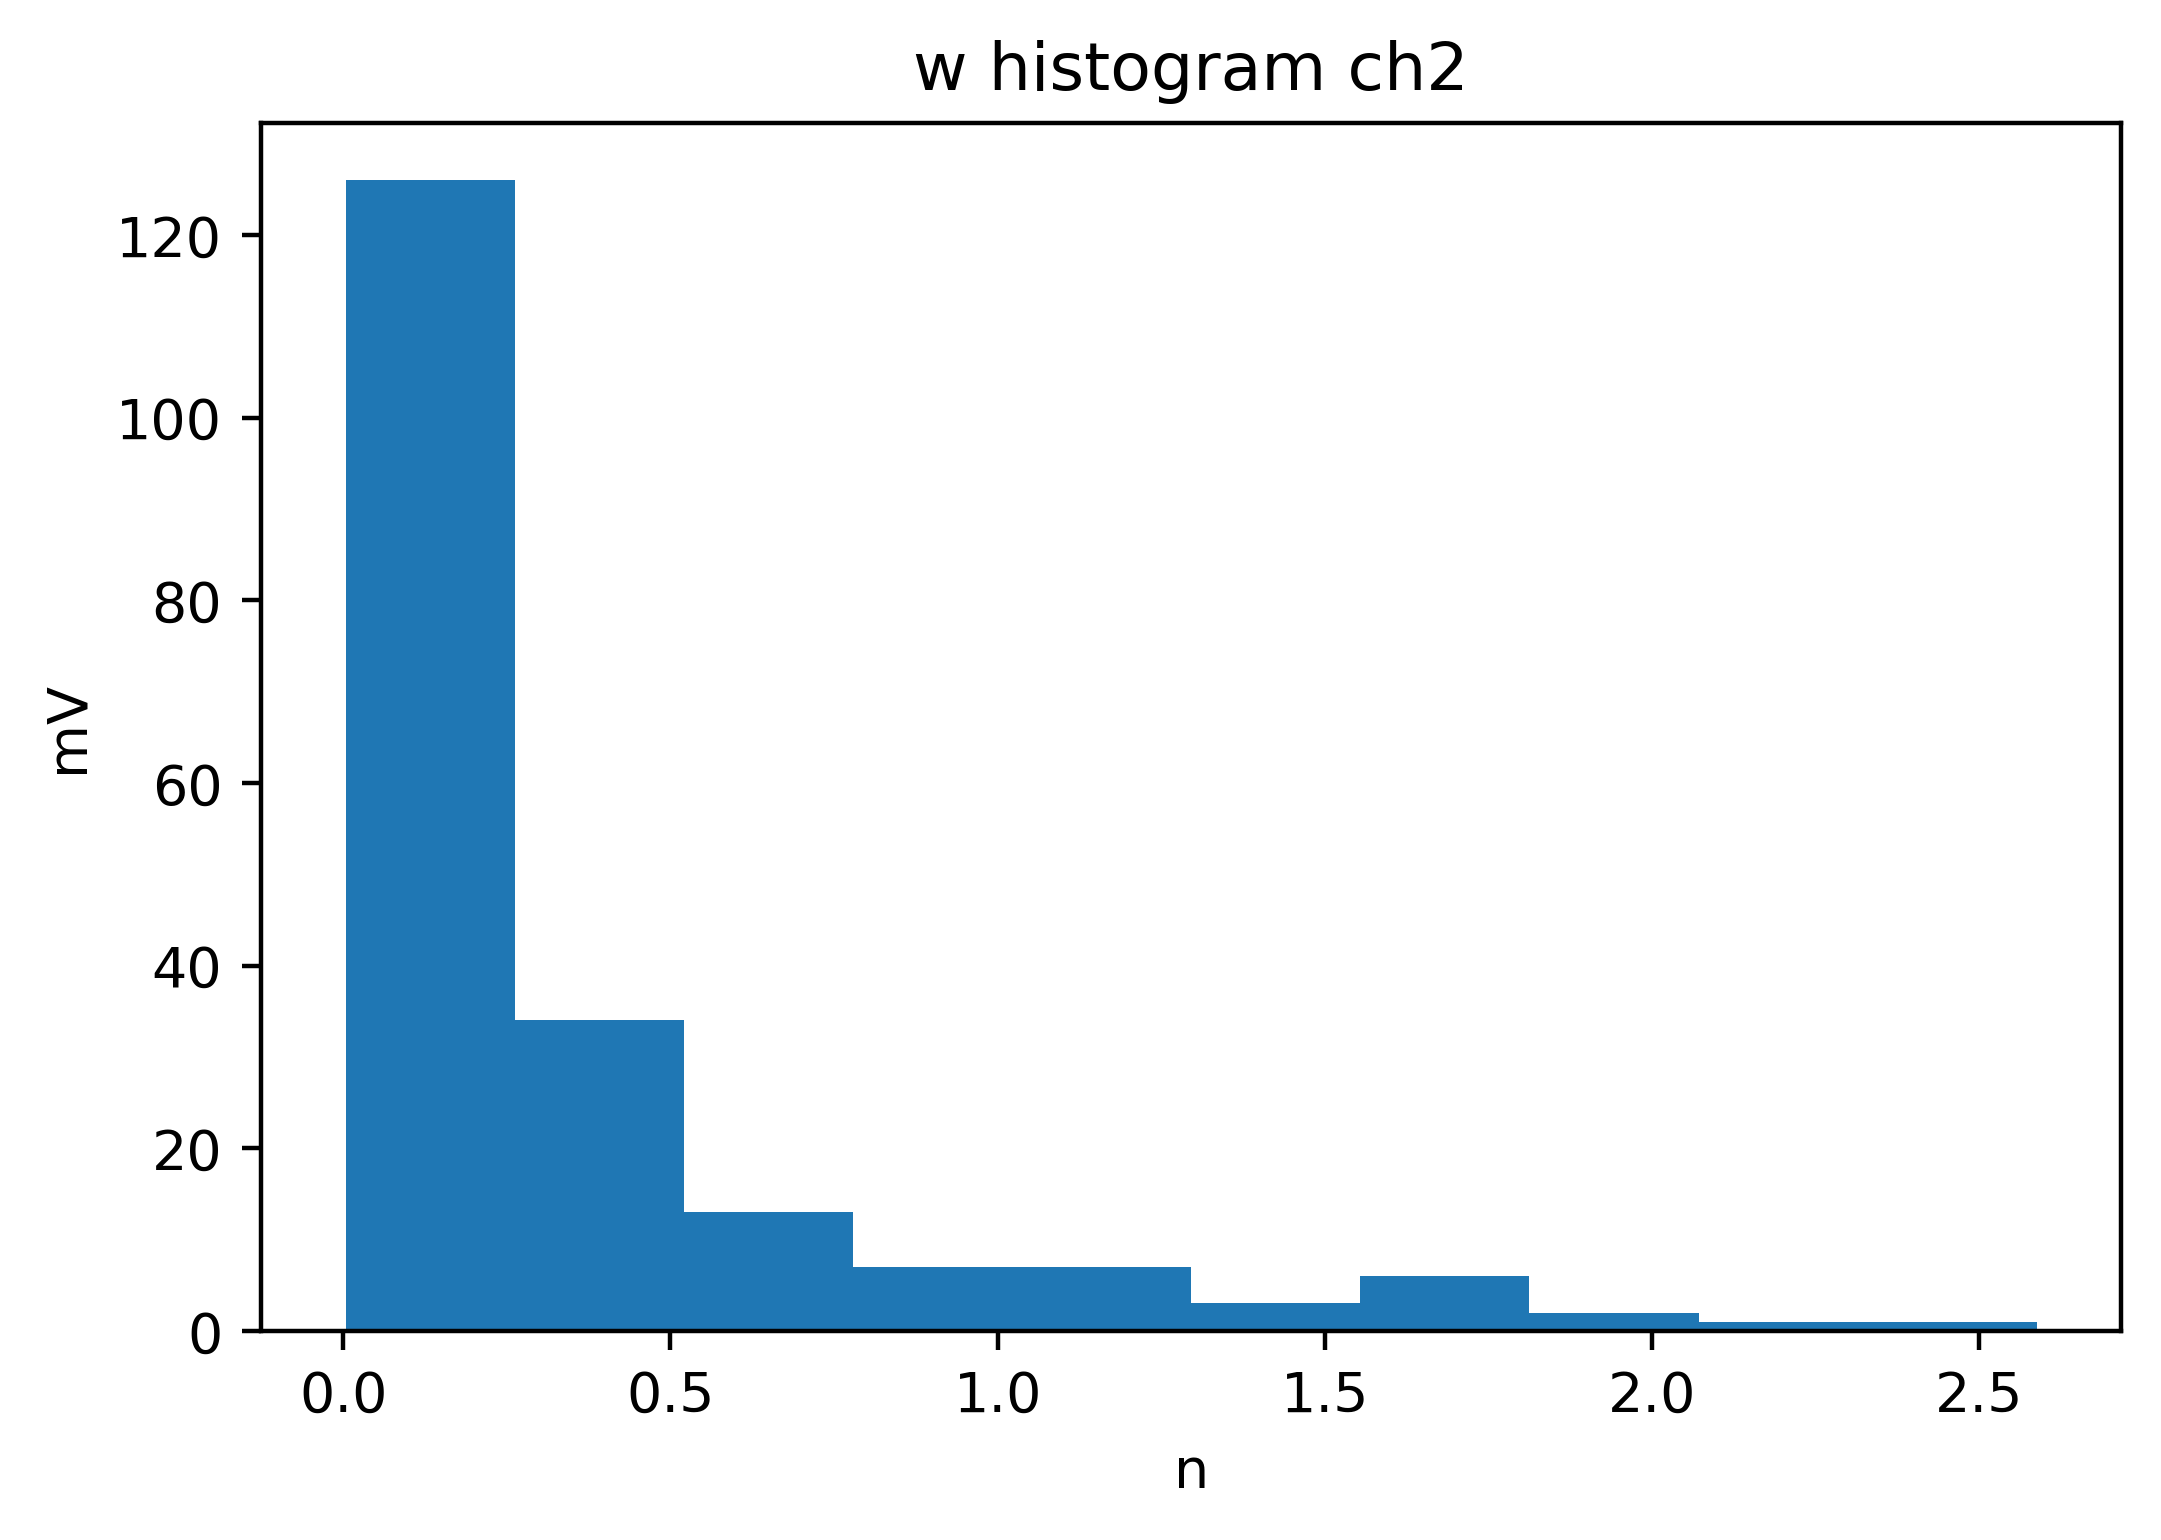

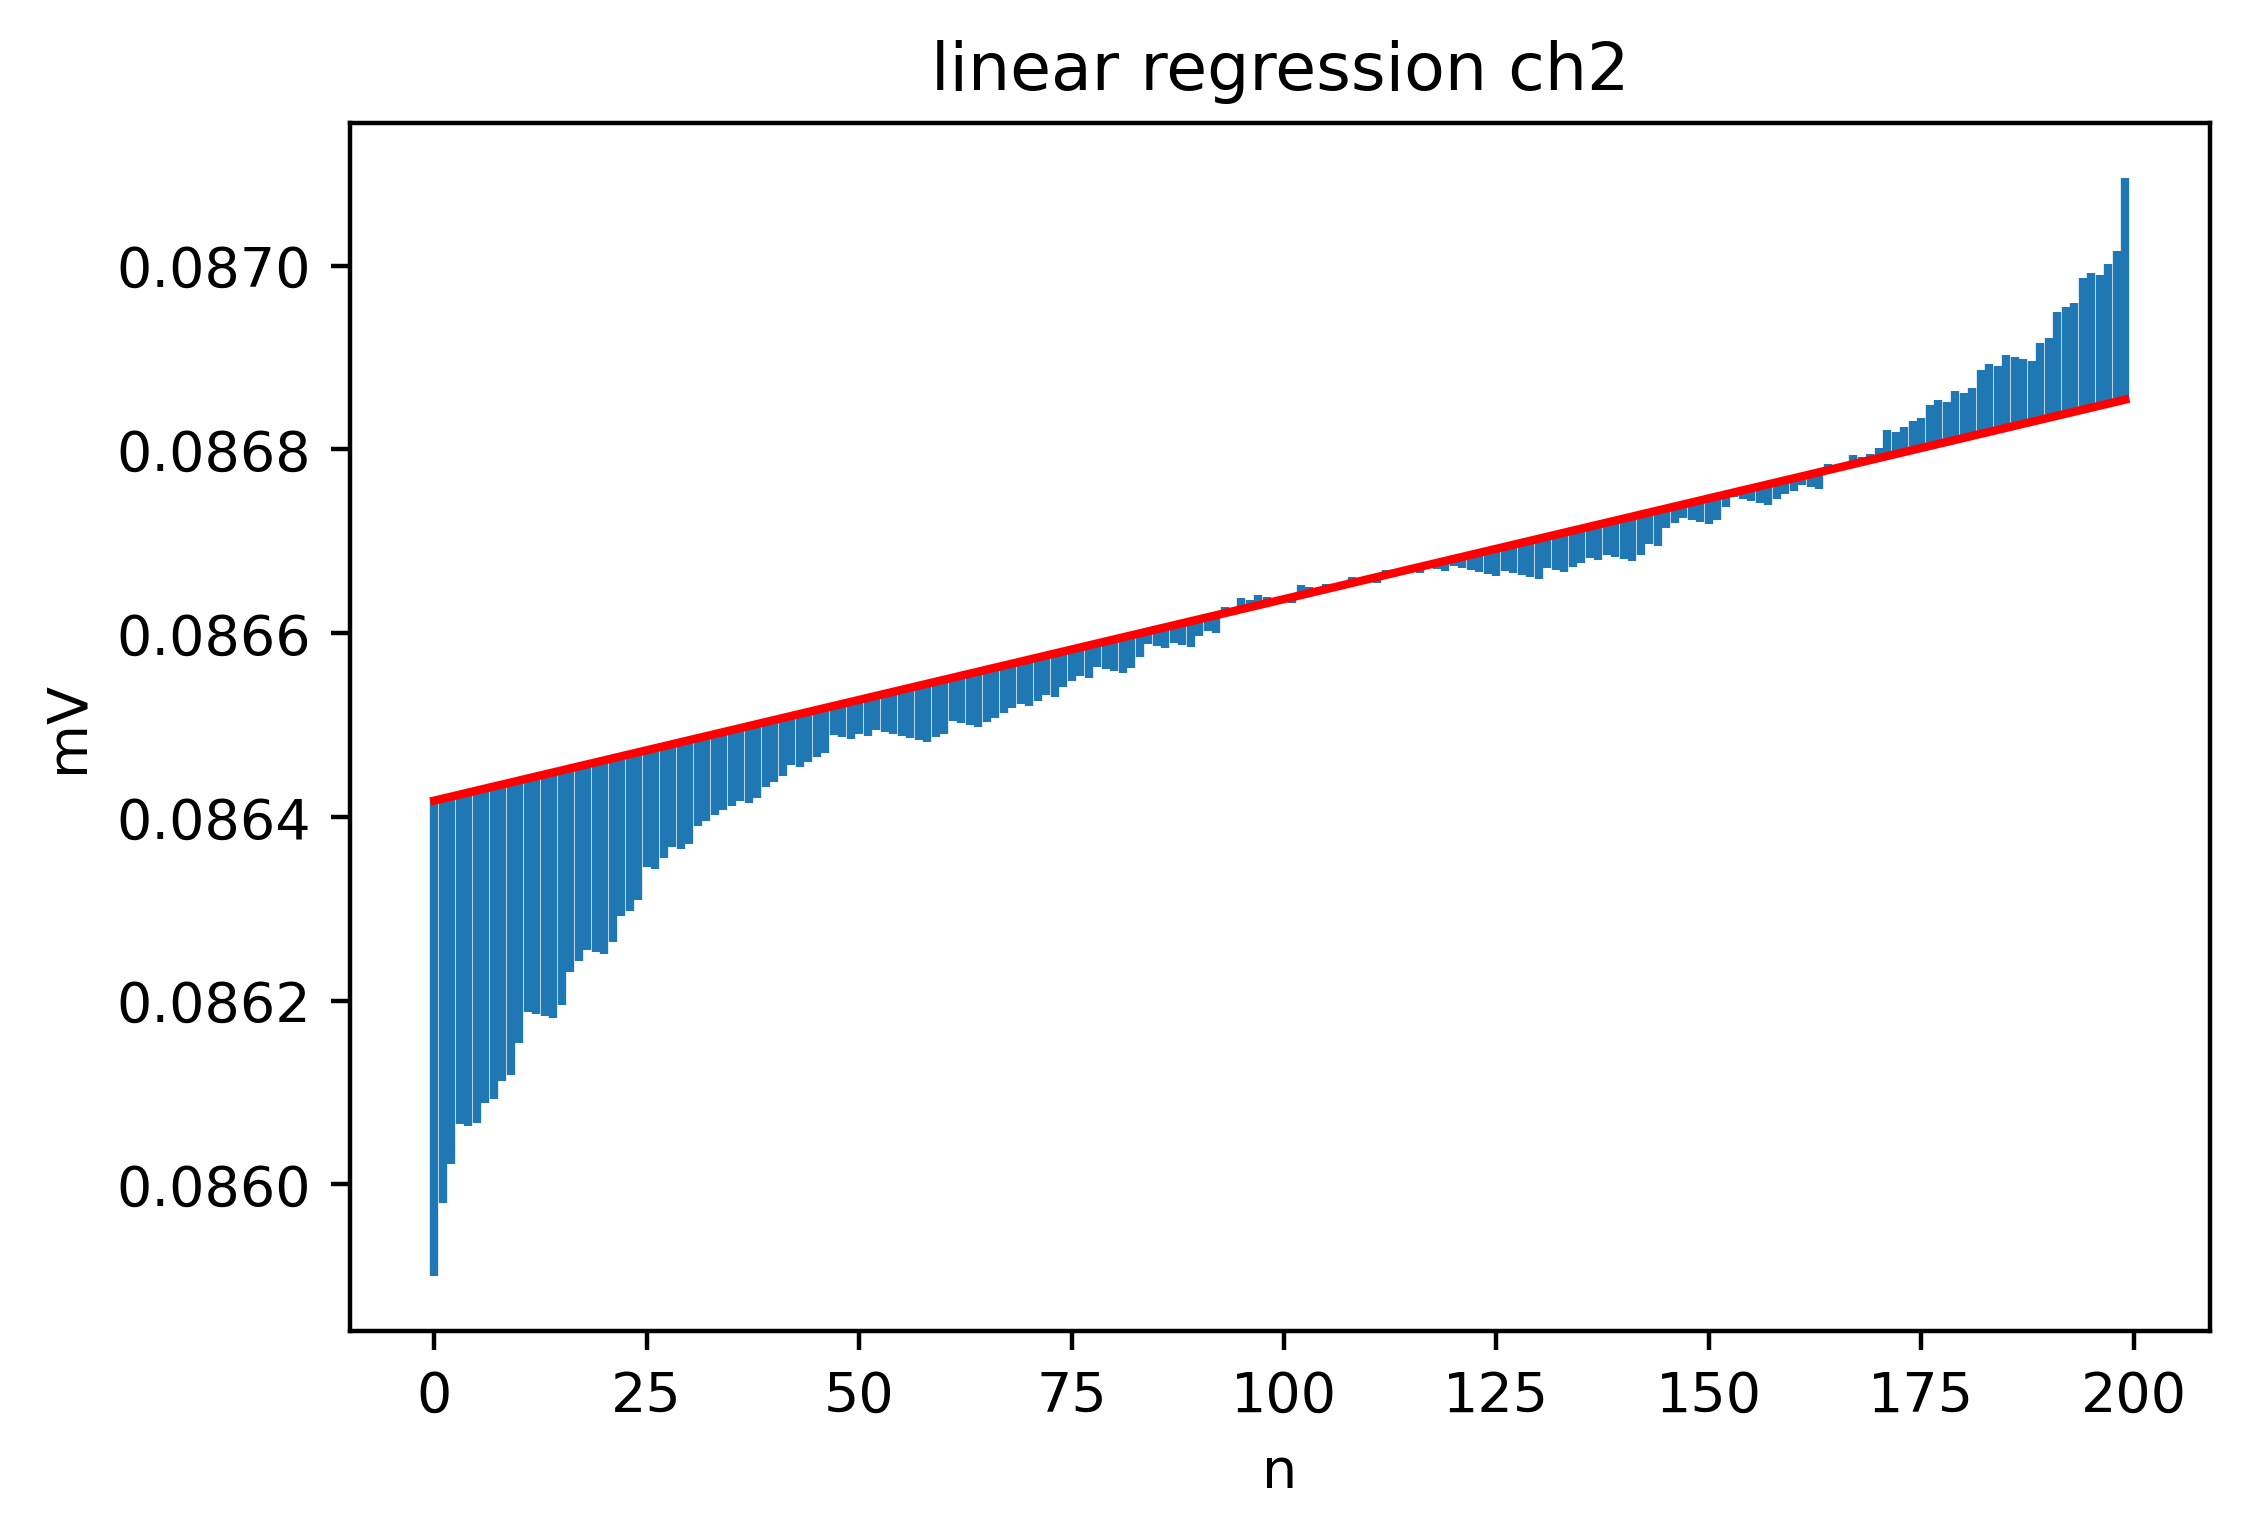

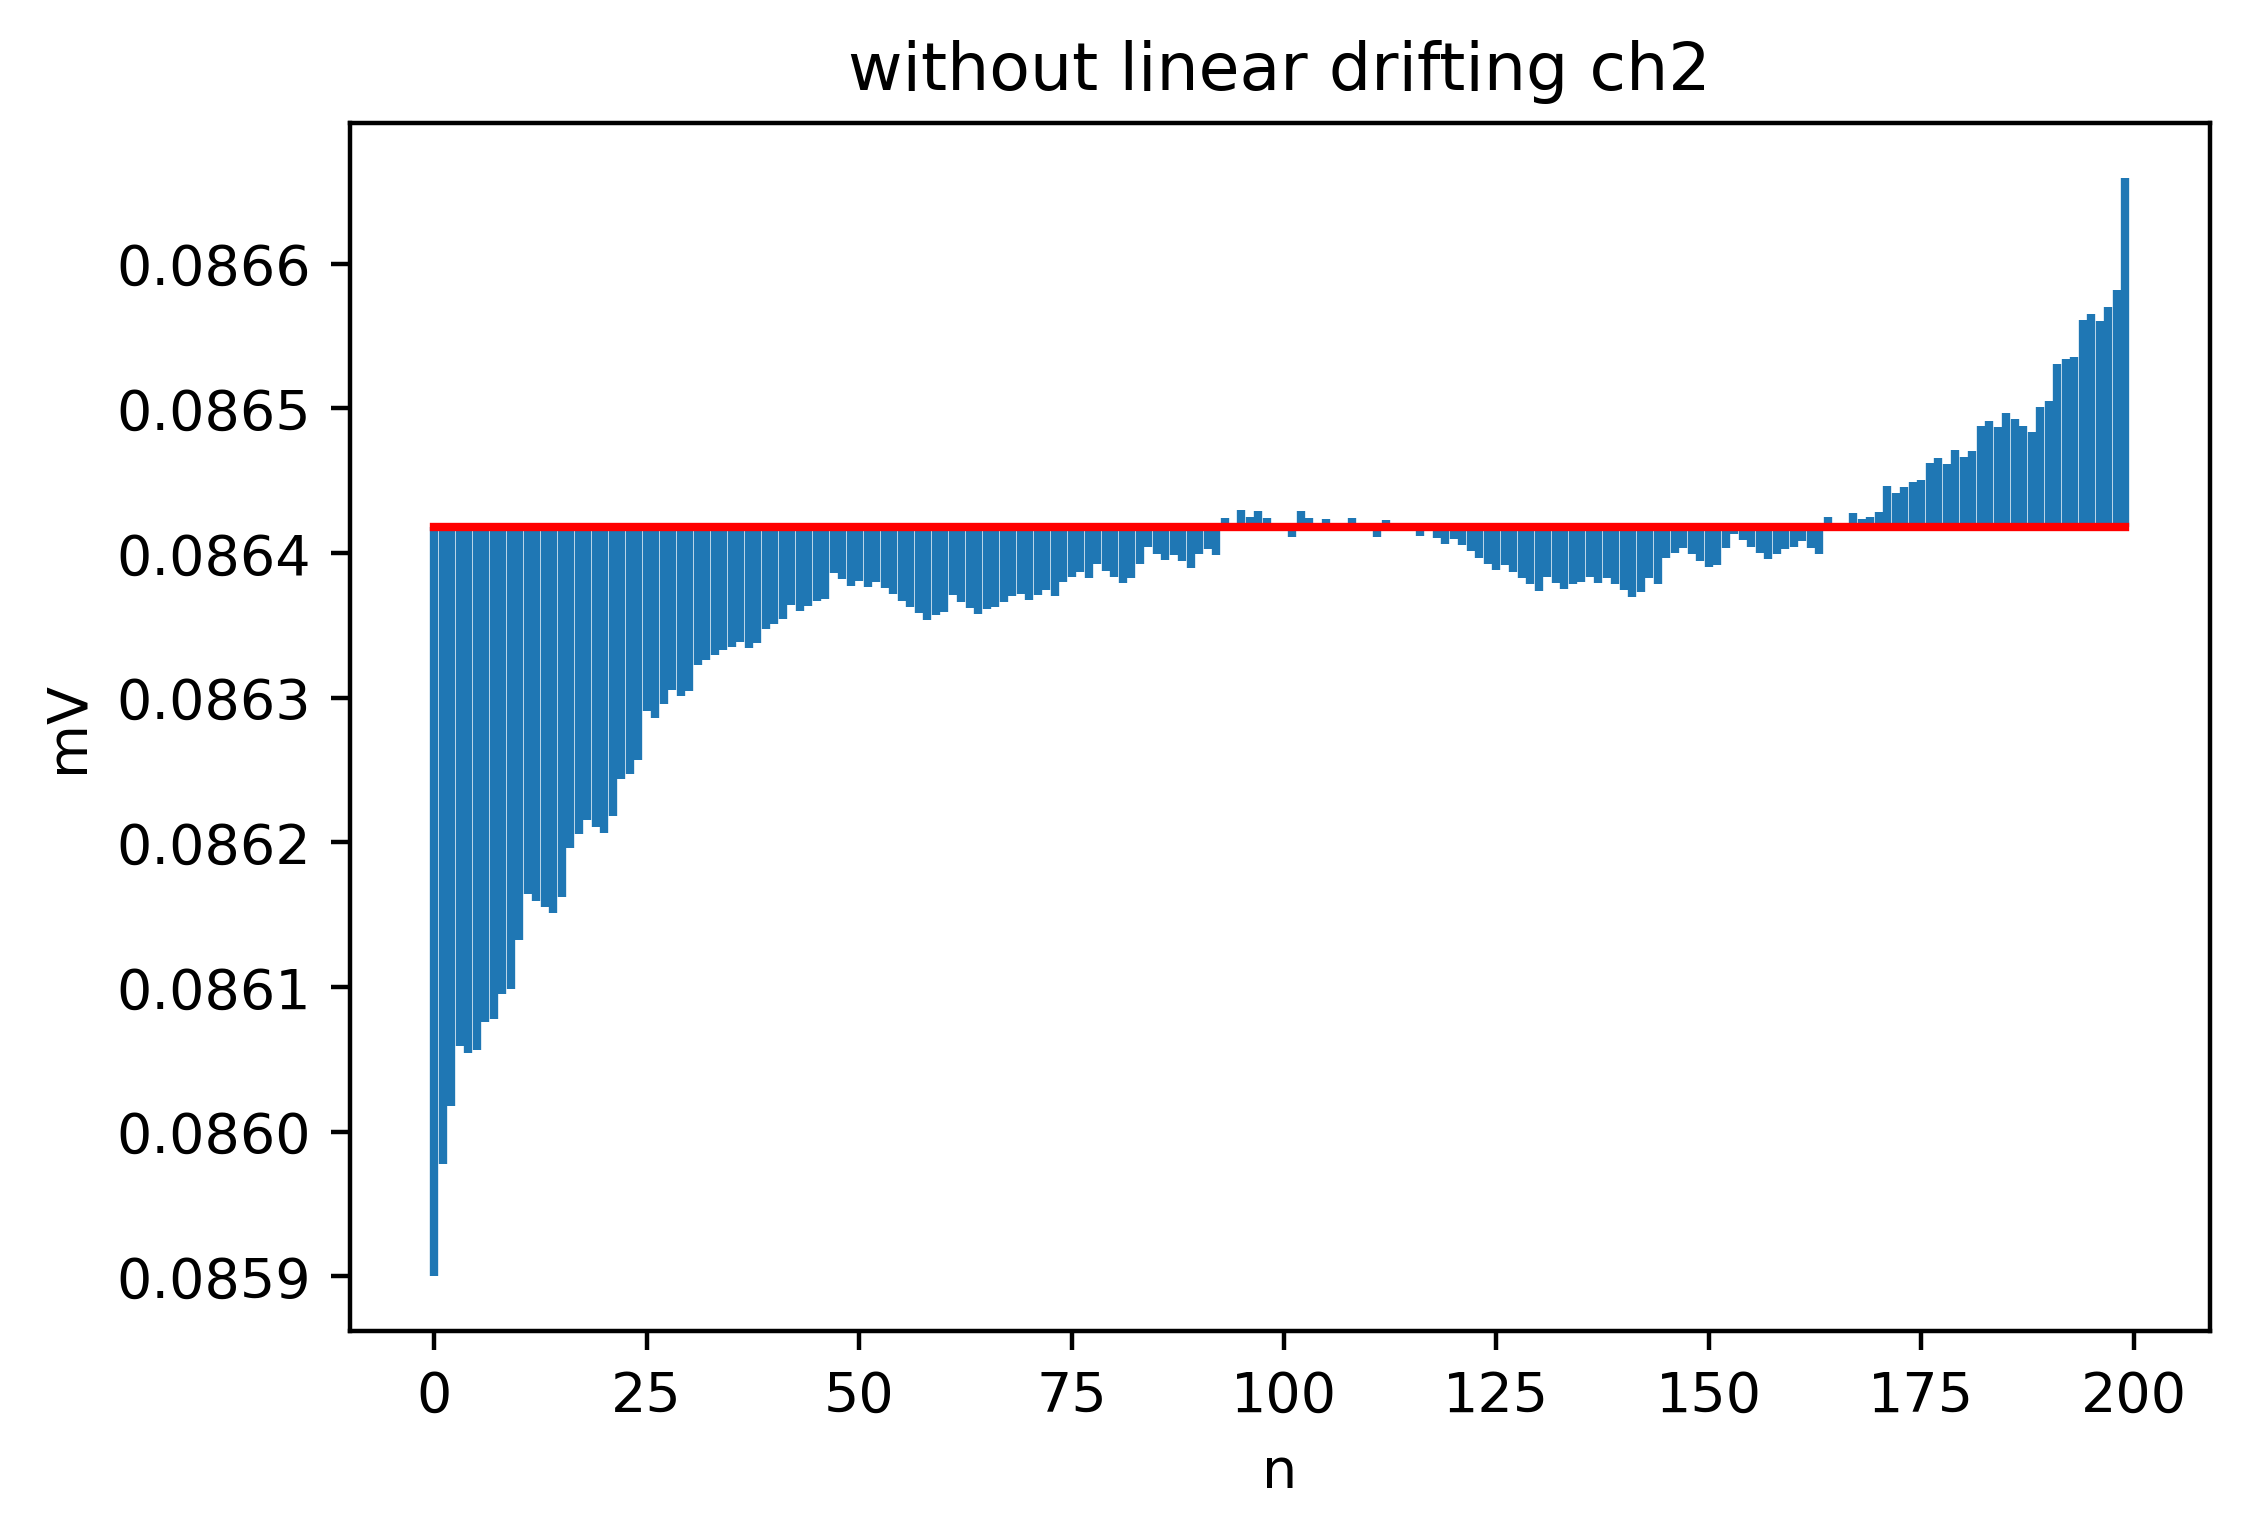

B0 0.08641775
B1 2.193467336683446e-06


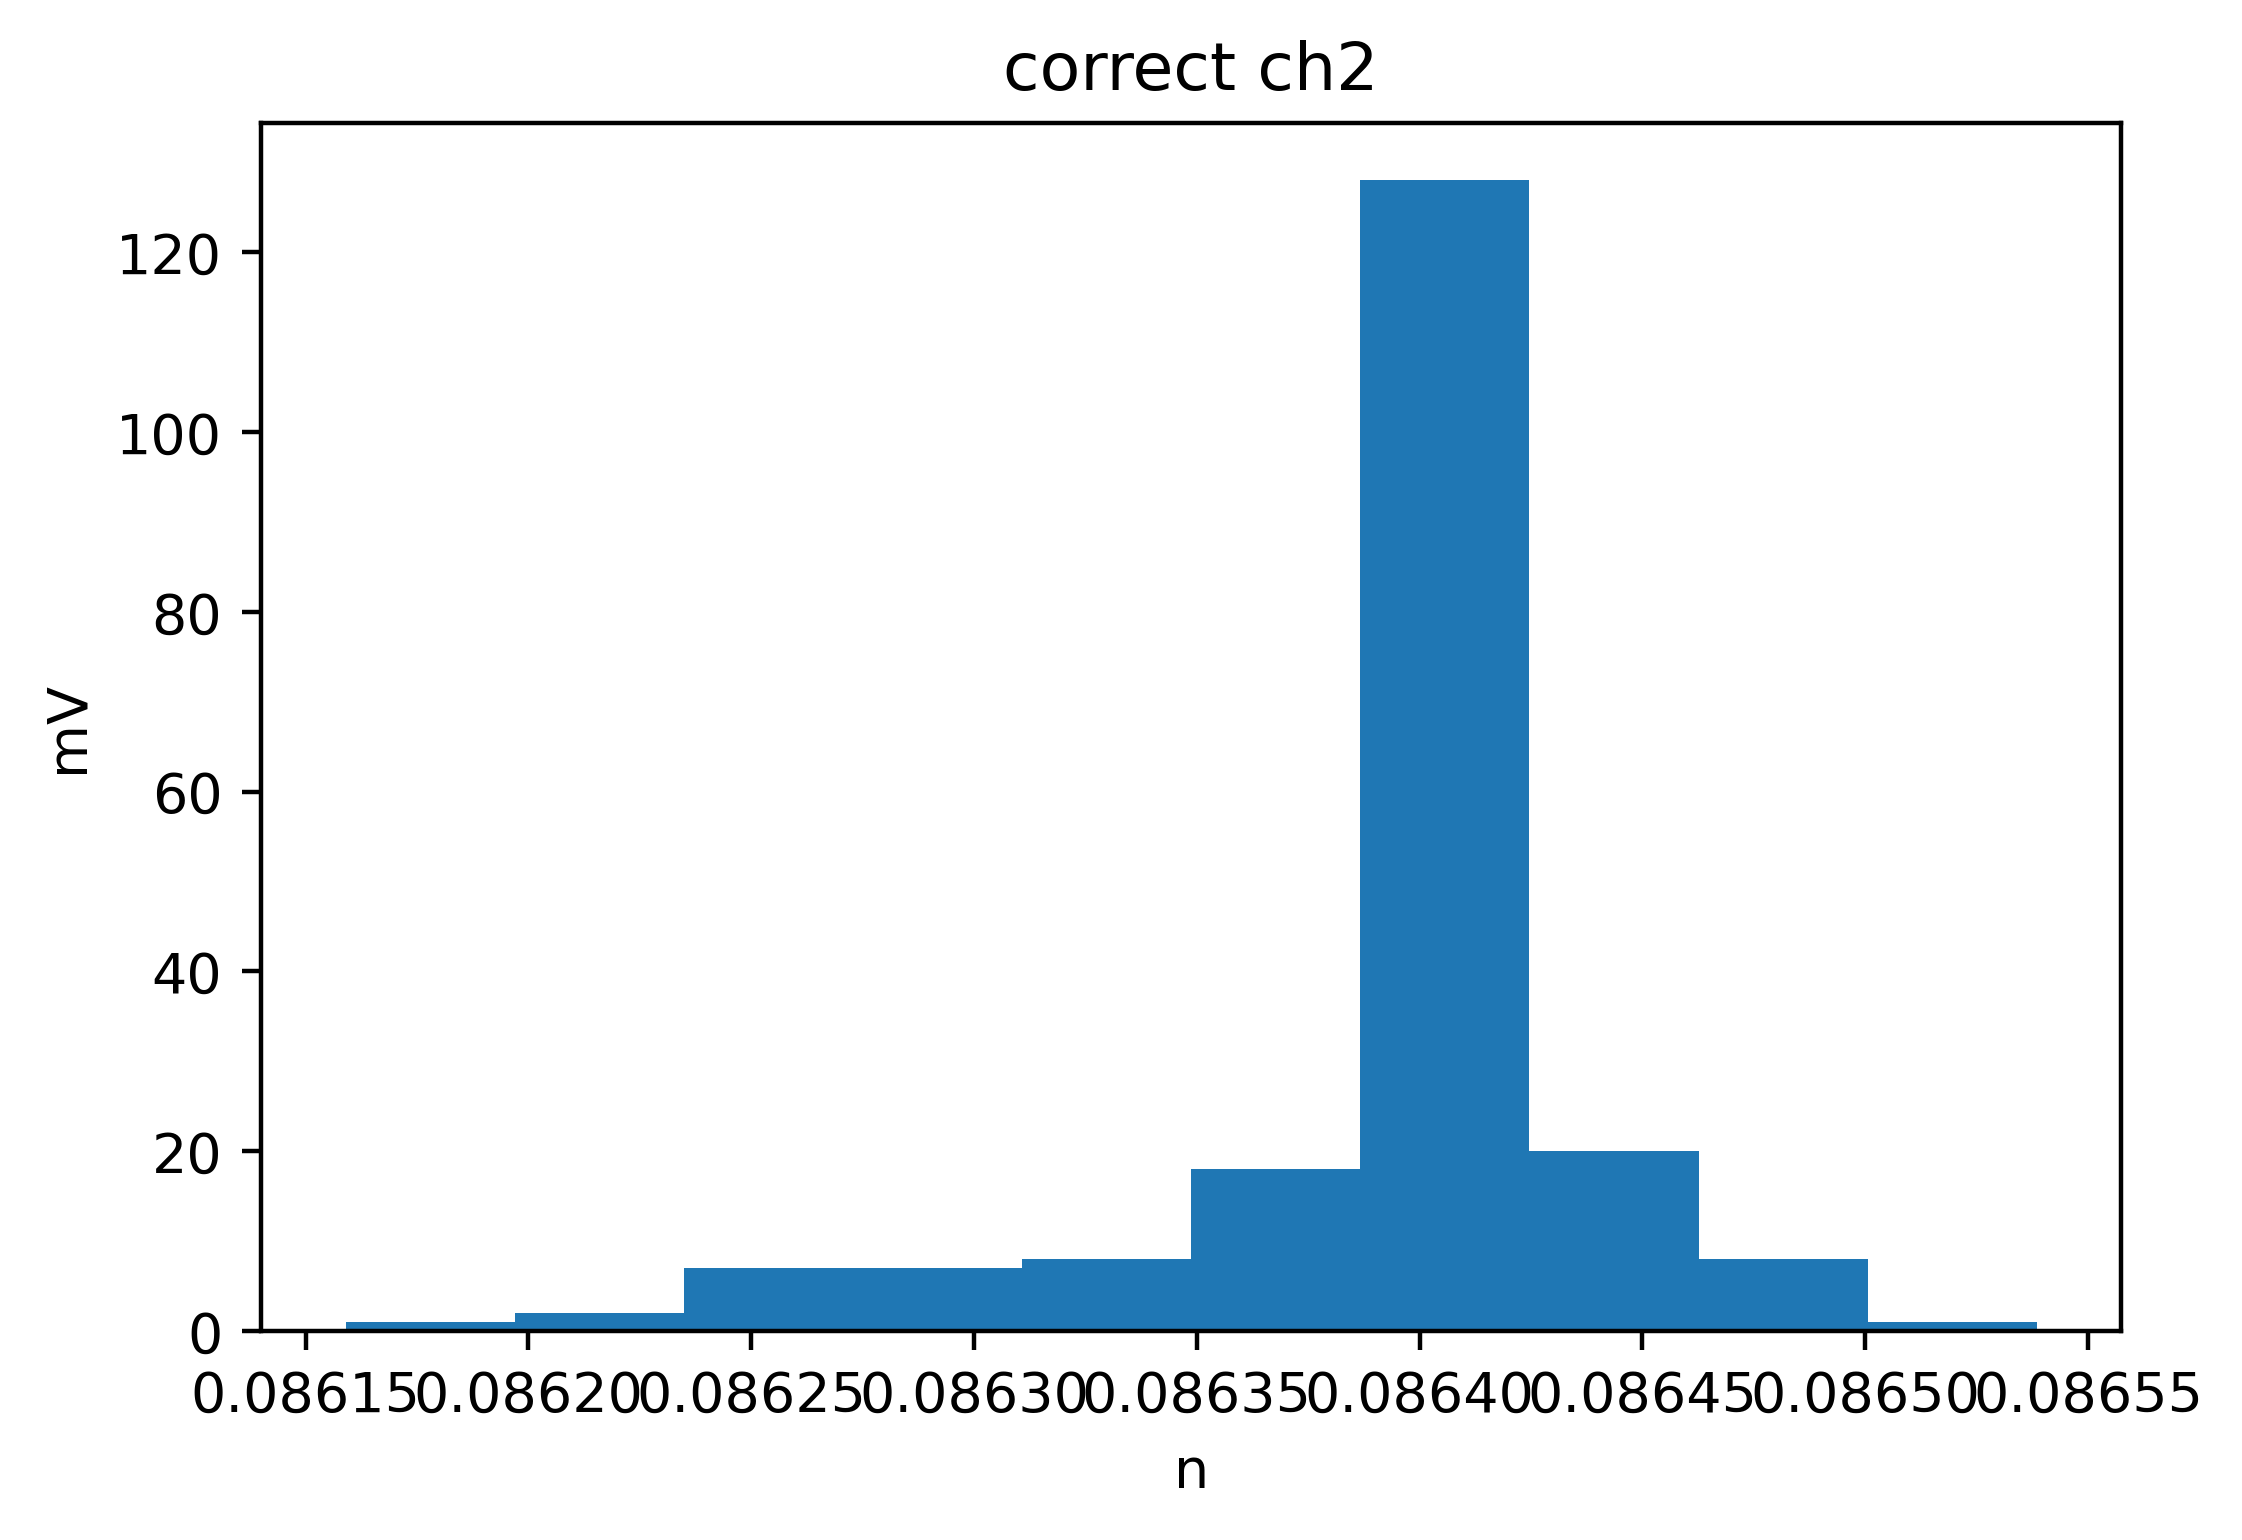

In [293]:
plotResult(data2[0],"ch2")

In [322]:
(w1,B0,B1) = getW(data1[0])
(w11,B01,B11) = getW(data2[0])
data1_corr = data1[0] - n*B1
data2_corr = data2[0] - n*B11
def Jour(R):
    data = [[(data1_corr[i] - w1[i] * EPS) * R, (data1_corr[i] +  w1[i] * EPS)*R] for i in range(len(n))]
    data2 = [[(data2_corr[i] - w11[i] * EPS),(data2_corr[i] +  w11[i] * EPS)] for i in range(len(n))]
    alldata = data + data2
    Vx = [None, None] # пересечение
    Ux = [None, None] # объеденение
    for interval in alldata:
        if Vx[0] is None:
            Vx = interval.copy()
            Ux = interval.copy()
        else:
            Vx[0] = max(Vx[0],interval[0])
            Vx[1] = min(Vx[1], interval[1])
            Ux[0] = min(Ux[0], interval[0])
            Ux[1] = max(Ux[1], interval[1])
    return (Vx[1] - Vx[0])/(Ux[1] - Ux[0])
        

In [390]:
R_interval = [0.001 * i + 0.8 for i in range(400)]
Jaccars = [Jour(i) for i in R_interval]
Jaccars.index(max(Jaccars)) *0.001 + 0.5

0.556

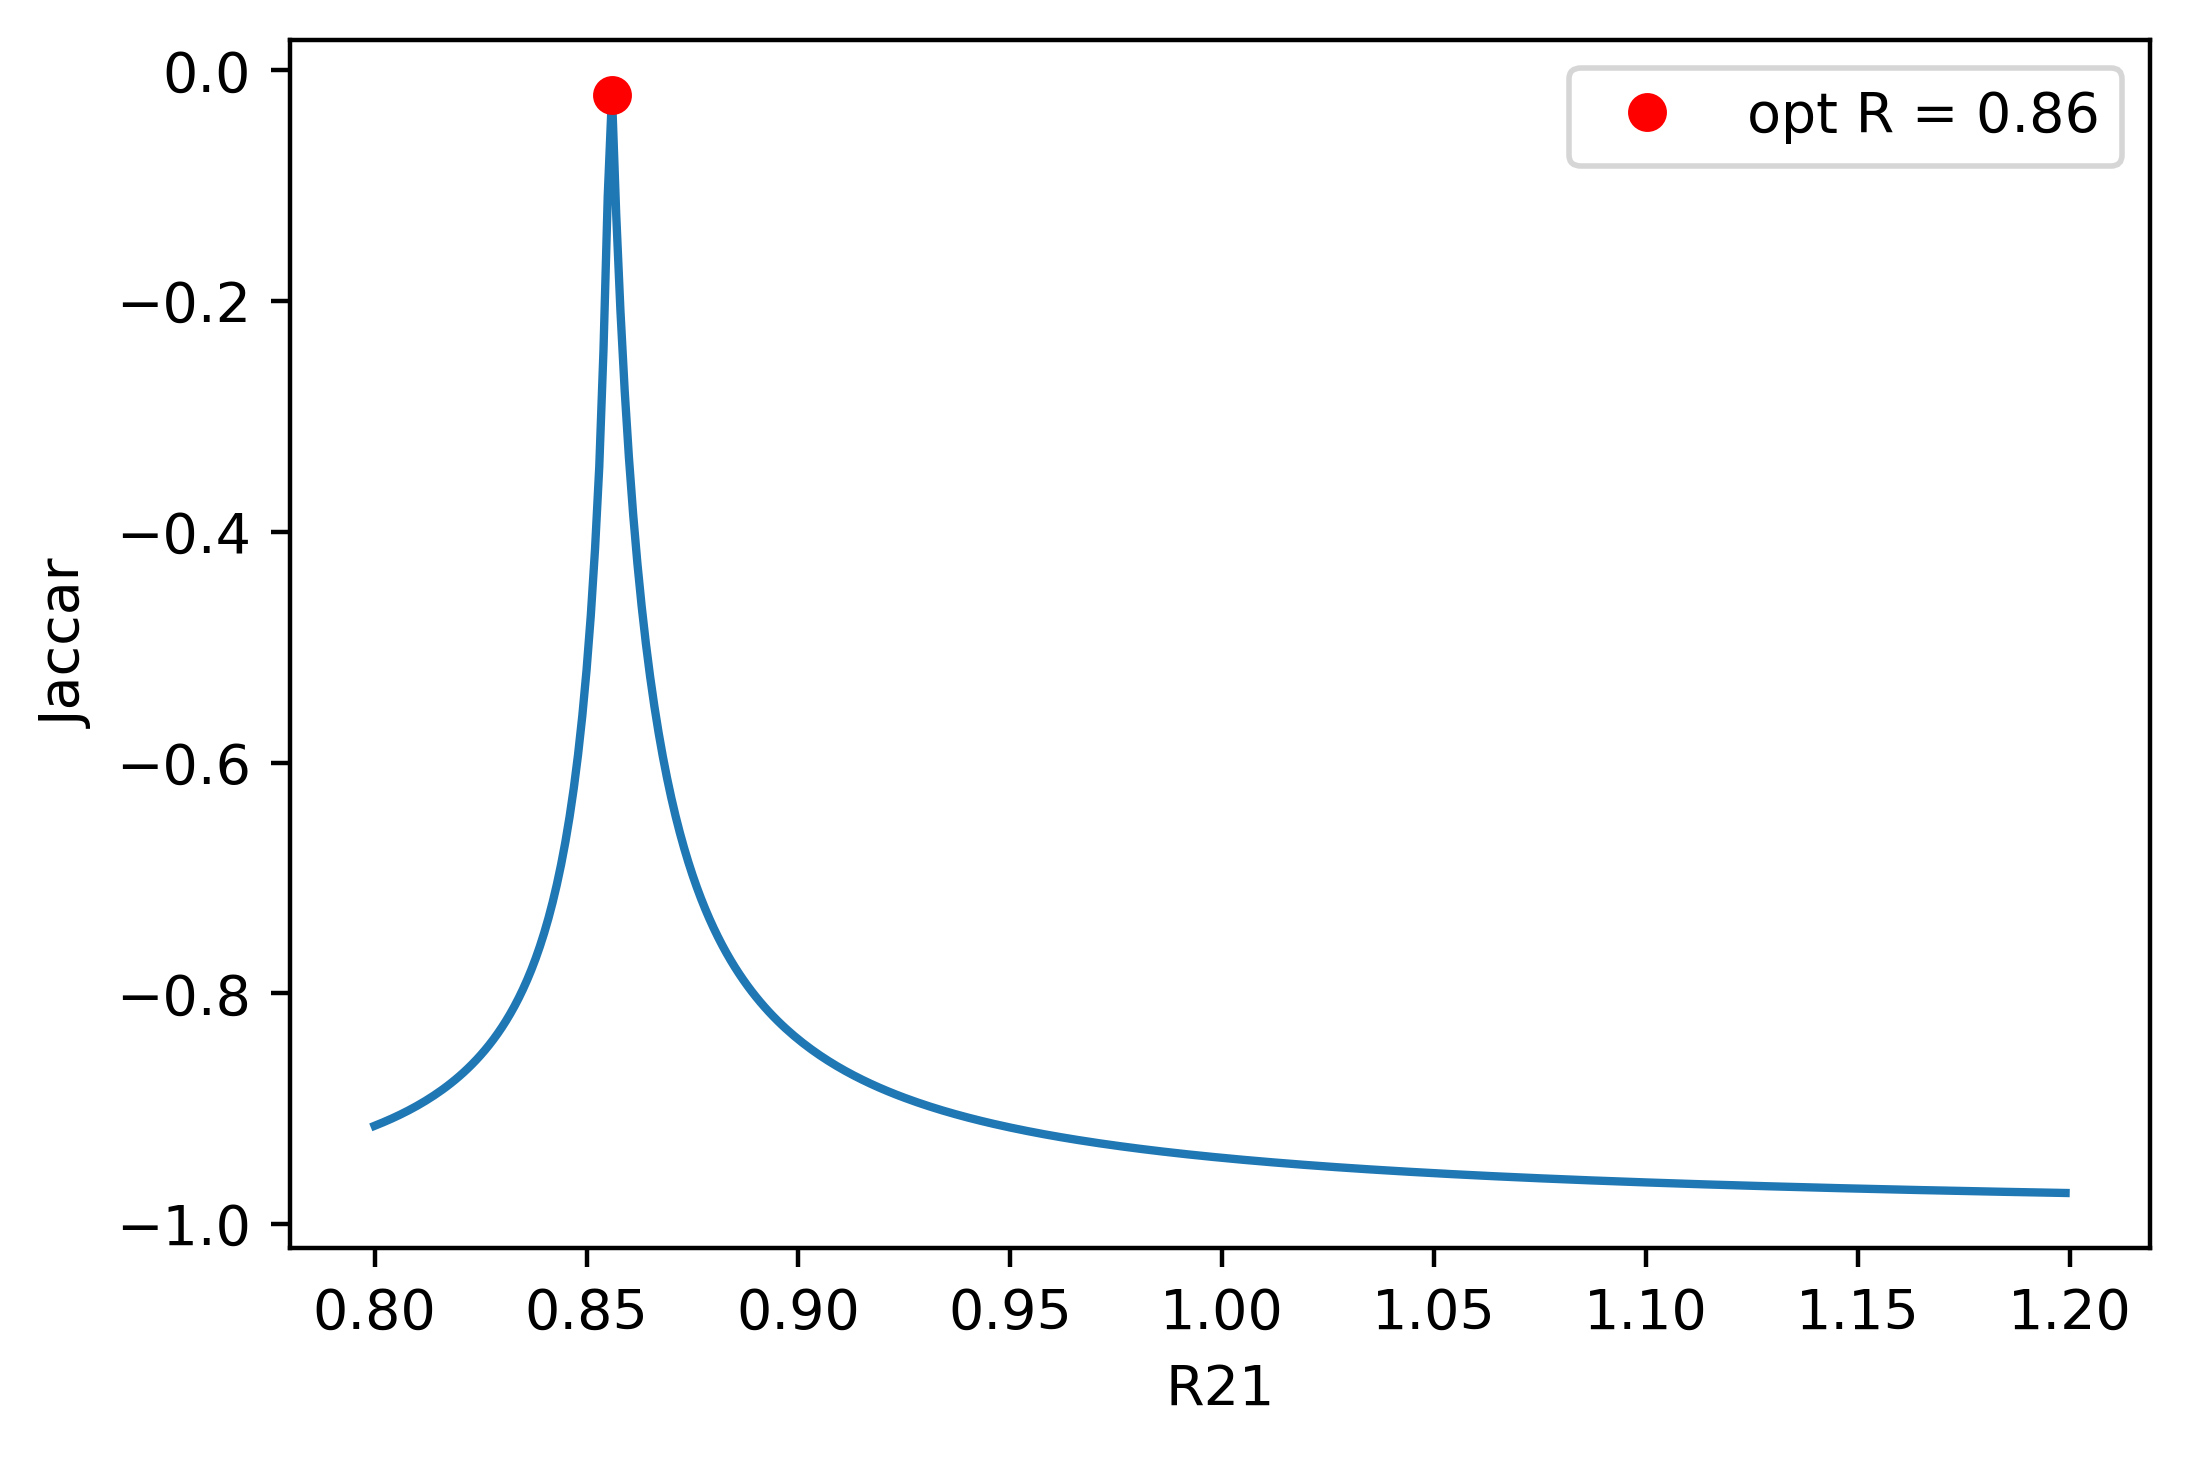

(0.8560000000000001, -0.021322227313729118)

In [396]:
R_opt = Jaccars.index(max(Jaccars)) *0.001 + 0.8
ax = plt.gca()
ax.set_ylabel("Jaccar")
ax.set_xlabel("R21")
ax.plot(R_interval,[Jour(i) for i in R_interval])
ax.plot(Jaccars.index(max(Jaccars)) *0.001 + 0.8,max(Jaccars),"ro",label ="opt R = " + str(round(R_opt,2)))
ax.legend()
plt.show()
R_opt,max(Jaccars)

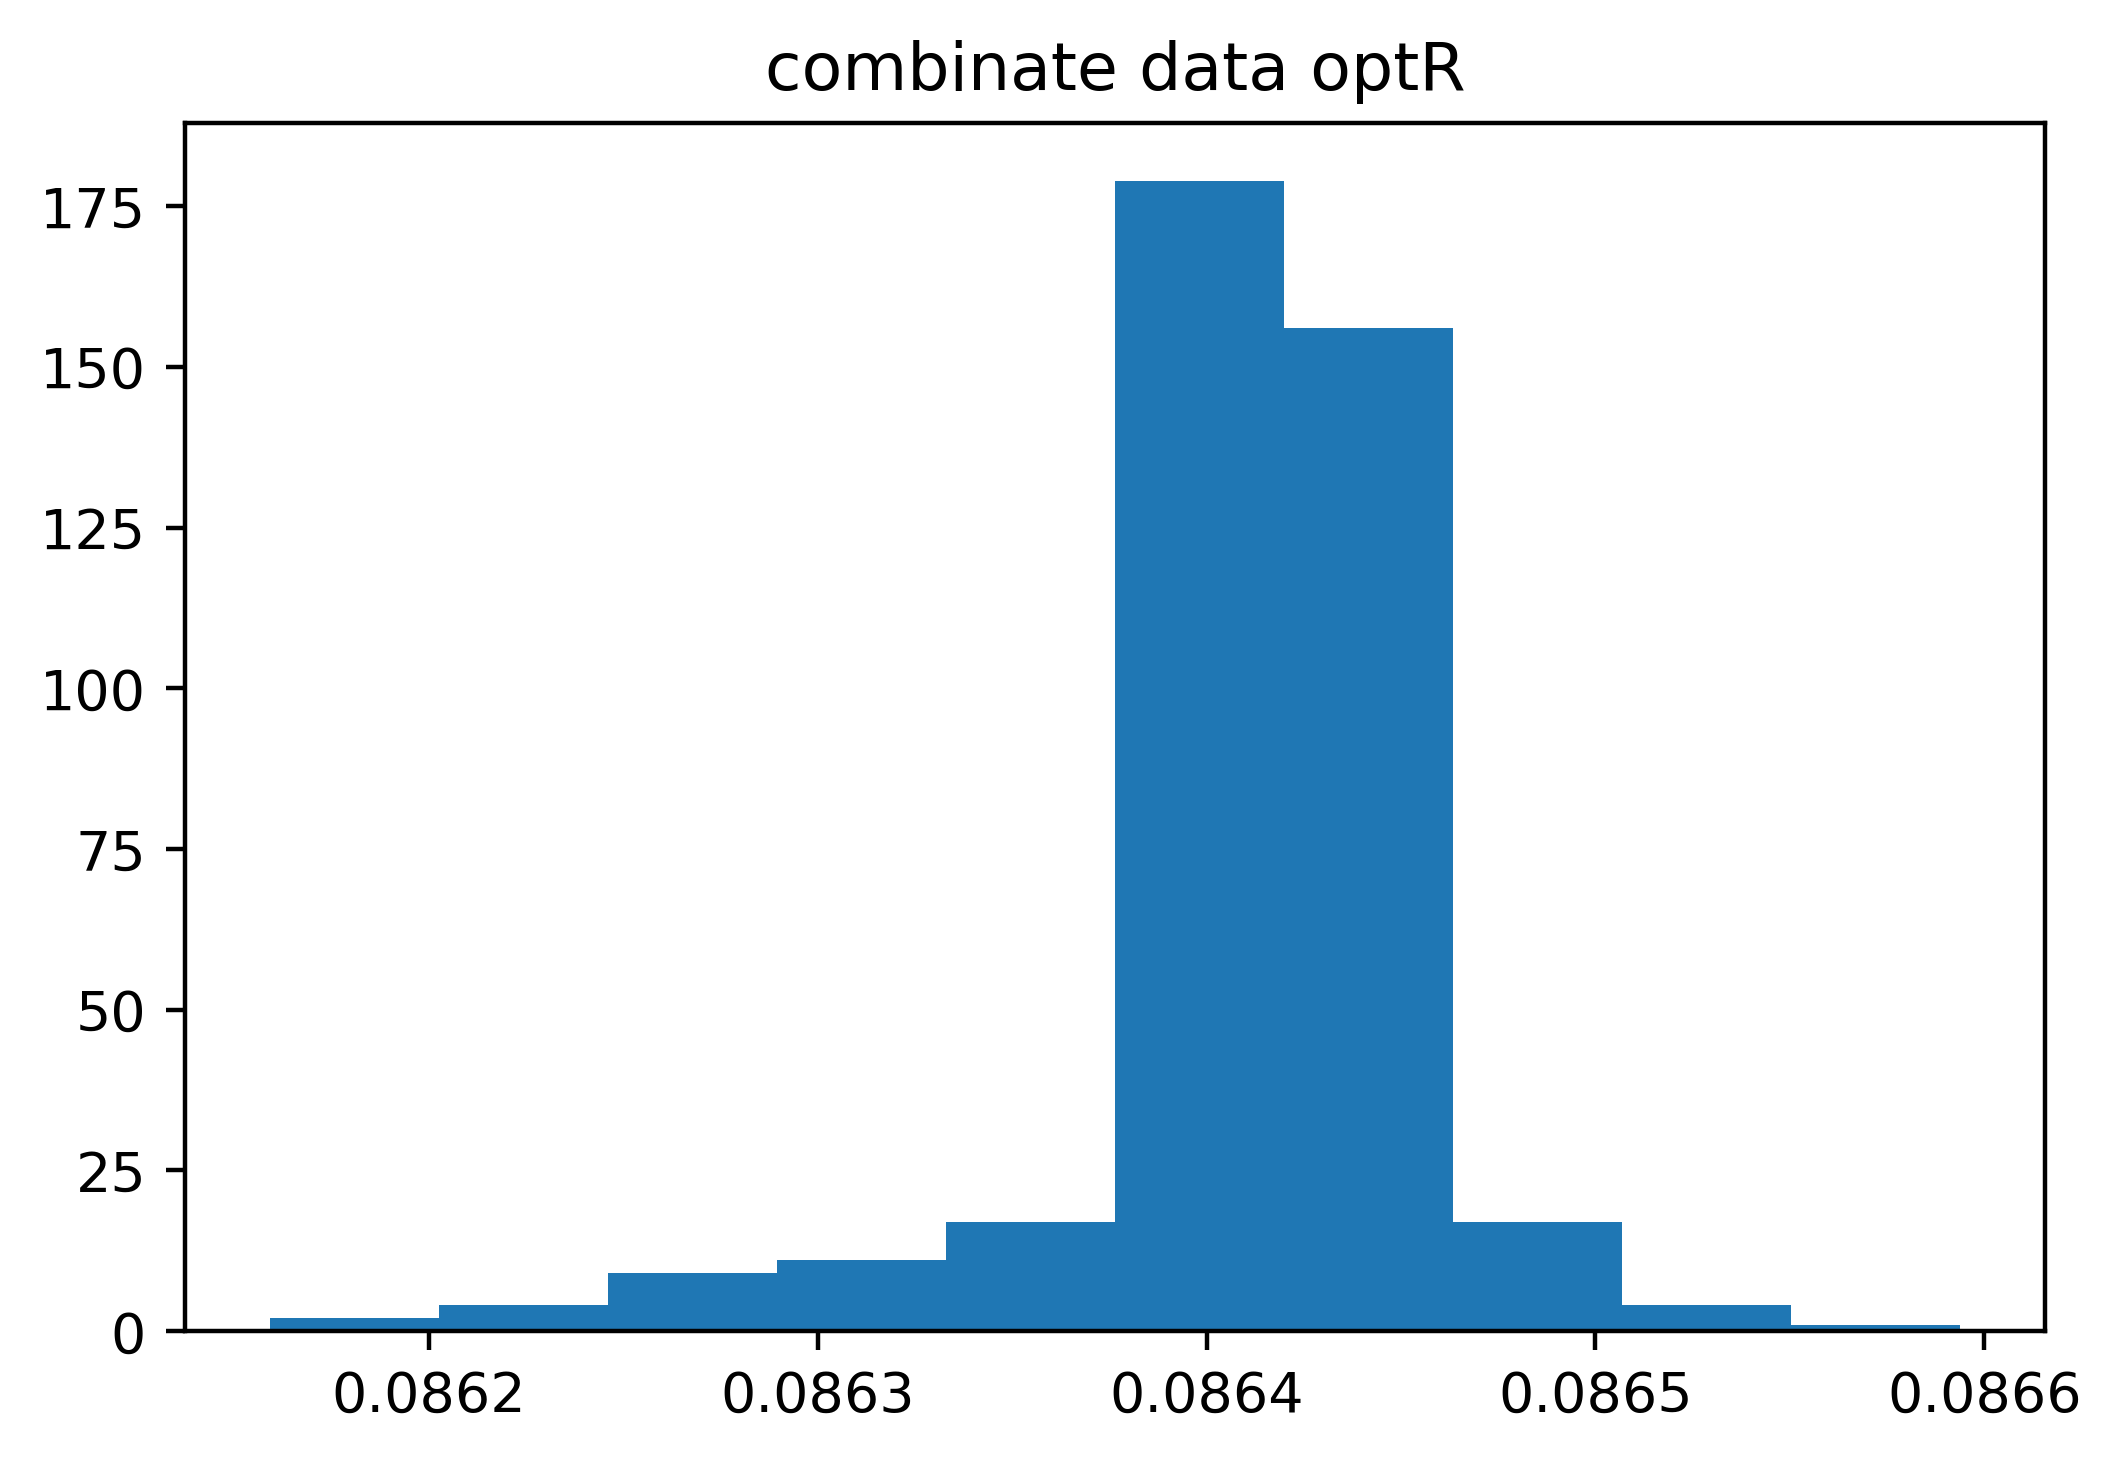

In [388]:
ax = plt.gca()
ax.set_title("combinate data optR")
ax.hist(list((data1[0] - B1*n)* R_opt) + list((data2[0] - B11*n)))
plt.show()

In [383]:
len(list((data1[0] - B1*n)* R_opt) + list((data2[0] - B11*n)))

400